# Discovering Modern NBA Player Archetypes Through Unsupervised Learning

**Author:** Nikhil Patel  
**Course:** DTSA 5510 - Unsupervised Algorithms in Machine Learning  
**Date:** October 2025

---

## Table of Contents

1. [Problem Description](#1-problem-description)
2. [Data Collection & Preprocessing](#2-data-collection--preprocessing)
3. [Exploratory Data Analysis (EDA)](#3-exploratory-data-analysis-eda)
4. [Model Development & Training](#4-model-development--training)
5. [Results & Interpretation](#5-results--interpretation)
6. [Discussion & Conclusions](#6-discussion--conclusions)
7. [References](#7-references)

---
## 1. Problem Description

### 1.1 Background and Motivation

The National Basketball Association (NBA) has traditionally categorized players into five positions: Point Guard (PG), Shooting Guard (SG), Small Forward (SF), Power Forward (PF), and Center (C). However, modern basketball has evolved significantly over the past decade, with the rise of "positionless basketball" - a style of play where traditional position boundaries blur and players are valued for their versatile skill sets rather than rigid positional assignments.

**Key Observations:**
- Centers now shoot three-pointers at high volumes (e.g., Karl-Anthony Towns, Nikola Jokic)
- Guards handle rebounding duties traditionally reserved for forwards (e.g., Luka Doncic, Russell Westbrook)
- The "stretch big" and "point forward" archetypes have become commonplace
- Teams increasingly value positional flexibility and multi-dimensional skill sets

### 1.2 Problem Statement

**Research Question:** *Can we use unsupervised learning techniques to identify natural player groupings based on statistical performance that better represent modern NBA roles than traditional positions?*

This project aims to:
1. Apply clustering algorithms to NBA player statistics to discover data-driven player archetypes
2. Determine if these clusters align with or diverge from traditional positional labels
3. Provide interpretable, actionable insights for basketball analytics applications

### 1.3 Business Value and Applications

Understanding modern player archetypes has significant practical value:

- **Roster Construction:** Identify gaps in team composition and target specific player types
- **Draft Strategy:** Evaluate prospects based on archetype rather than traditional position
- **Trade Analysis:** Find statistically similar players as potential trade targets
- **Player Development:** Guide young players toward specific role development
- **Lineup Optimization:** Build balanced lineups with complementary skill sets

### 1.4 Unsupervised Learning Approach

This problem is ideal for unsupervised learning because:

1. **No Predefined Labels:** We want to discover natural groupings rather than confirm existing categories
2. **Pattern Discovery:** The goal is to find hidden patterns in multi-dimensional player statistics
3. **Hypothesis Generation:** Clusters can reveal novel player archetypes not previously conceptualized
4. **Data-Driven:** Removes human bias in player categorization

**Clustering Algorithms to Explore:**
- **K-Means:** Partition-based clustering for identifying spherical clusters
- **Hierarchical Clustering:** Understand nested player groupings and relationships
- **DBSCAN:** Identify outlier players and density-based groups
- **Gaussian Mixture Models (GMM):** Probabilistic soft clustering with flexible cluster shapes

### 1.5 Success Criteria

A successful analysis will produce:
1. **Statistically Valid Clusters:** Silhouette score > 0.3, well-separated groups
2. **Interpretable Archetypes:** Clear statistical profiles for each cluster
3. **Novel Insights:** Discoveries that challenge or refine traditional position thinking
4. **Actionable Recommendations:** Practical applications for team decision-making

---
## 2. Data Collection & Preprocessing

### 2.1 Environment Setup

In [431]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np
from pandas.plotting import parallel_coordinates

# NBA Data
from nba_api.stats.endpoints import leaguedashplayerstats
from nba_api.stats.static import players

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

# Machine Learning - Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage

# Machine Learning - Metrics
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors

# Dimensionality Reduction
from sklearn.manifold import TSNE

# Yellowbrick for clustering visualization
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Other utilities
from math import pi

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# Create figures directory if it doesn't exist
import os
figures_dir = 'figures'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
print("All libraries imported successfully!")

All libraries imported successfully!


In [432]:
# Configure plotting styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set default figure size
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

# Plotly default template
pio.templates.default = "plotly_white"

print("Plotting configuration complete!")

Plotting configuration complete!


### 2.2 Data Collection from NBA API

We'll collect player statistics from the 2024-25 NBA season using the `nba_api` library. Our focus will be on players who have played a significant number of games (minimum 30 games) to ensure statistical reliability.

In [433]:
# Collect NBA player statistics for 2024-25 season
def collect_nba_data(season='2024-25', min_games=30):
    """
    Collect NBA player statistics using nba_api.
    
    Parameters:
    -----------
    season : str
        NBA season (e.g., '2024-25')
    min_games : int
        Minimum games played filter
    
    Returns:
    --------
    pd.DataFrame : Player statistics
    """
    print(f"Fetching NBA player data for {season} season...")
    
    # Fetch player stats
    player_stats = leaguedashplayerstats.LeagueDashPlayerStats(
        season=season,
        season_type_all_star='Regular Season',
        per_mode_detailed='PerGame'
    )
    
    # Convert to DataFrame
    df = player_stats.get_data_frames()[0]
    
    # Filter by minimum games played
    df_filtered = df[df['GP'] >= min_games].copy()
    
    print(f"Data collected: {len(df)} total players, {len(df_filtered)} players with >={min_games} games")
    
    return df_filtered

# Collect the data
nba_data = collect_nba_data(season='2024-25', min_games=30)

Fetching NBA player data for 2024-25 season...
Data collected: 569 total players, 411 players with >=30 games


In [434]:
# Display first few rows
print("Dataset Shape:", nba_data.shape)
print("\nFirst 5 rows:")
nba_data.head()

Dataset Shape: (411, 67)

First 5 rows:


,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,...,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,TEAM_COUNT
1,1631260,AJ Green,AJ,1610612749,MIL,25.0,73,44,29,0.603,...,520,136,394,278,83,342,281,44,318,1
3,203932,Aaron Gordon,Aaron,1610612743,DEN,29.0,51,33,18,0.647,...,84,277,89,98,26,127,134,44,124,1
4,1628988,Aaron Holiday,Aaron,1610612745,HOU,28.0,62,39,23,0.629,...,415,413,350,363,142,422,281,44,403,1
5,1630174,Aaron Nesmith,Aaron,1610612754,IND,25.0,45,29,16,0.644,...,182,52,169,147,53,193,281,44,180,1
6,1630598,Aaron Wiggins,Aaron,1610612760,OKC,26.0,76,62,14,0.816,...,170,349,326,146,14,187,159,44,177,1


In [435]:
# Display all available columns
print("Available Columns:")
print(nba_data.columns.tolist())

Available Columns:
['PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'AGE', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'NBA_FANTASY_PTS', 'DD2', 'TD3', 'WNBA_FANTASY_PTS', 'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK', 'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK', 'PF_RANK', 'PFD_RANK', 'PTS_RANK', 'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK', 'DD2_RANK', 'TD3_RANK', 'WNBA_FANTASY_PTS_RANK', 'TEAM_COUNT']


### 2.3 Data Cleaning and Feature Selection

We'll select relevant features that capture different aspects of player performance:
- **Scoring:** Points (PTS), Field Goal % (FG_PCT), Three-Point % (FG3_PCT), Free Throw % (FT_PCT)
- **Playmaking:** Assists (AST), Assist/Turnover Ratio
- **Rebounding:** Rebounds (REB), Offensive/Defensive Rebounds
- **Defense:** Steals (STL), Blocks (BLK)
- **Shooting Volume:** Three-Point Attempts (FG3A), Field Goal Attempts (FGA)
- **Efficiency:** True Shooting %, Usage Rate (if available)

In [436]:
# Check for missing values
print("Missing Values Summary:")
missing_summary = nba_data.isnull().sum()
missing_summary[missing_summary > 0]

Missing Values Summary:


Series([], dtype: int64)

In [437]:
# Select relevant features for clustering
# Include more granular stats to enable better cluster separation
feature_cols = [
    'PTS',      # Points per game
    'AST',      # Assists per game
    'REB',      # Total rebounds per game
    'OREB',     # Offensive rebounds (NEW - interior presence)
    'DREB',     # Defensive rebounds (NEW - defensive positioning)
    'STL',      # Steals per game
    'BLK',      # Blocks per game
    'FGM',      # Field goals made (NEW - volume scoring)
    'FGA',      # Field goal attempts per game
    'FG_PCT',   # Field goal percentage
    'FG3M',     # Three-pointers made (NEW - perimeter volume)
    'FG3A',     # Three-point attempts per game
    'FG3_PCT',  # Three-point percentage
    'FTM',      # Free throws made (NEW - paint presence/contact)
    'FTA',      # Free throw attempts (NEW - drives to basket)
    'FT_PCT',   # Free throw percentage
    'TOV',      # Turnovers per game
    'PF',       # Personal fouls (NEW - defensive aggression)
    'MIN'       # Minutes per game
]

# Create working dataset with selected features
df_work = nba_data[['PLAYER_NAME'] + feature_cols].copy()

print(f"Working dataset shape: {df_work.shape}")
print(f"Features selected: {len(feature_cols)}")
df_work.head()

Working dataset shape: (411, 20)
Features selected: 19


,PLAYER_NAME,PTS,AST,REB,OREB,DREB,STL,BLK,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,TOV,PF,MIN
1,AJ Green,7.4,1.5,2.4,0.2,2.1,0.5,0.1,2.5,5.8,0.429,2.1,5.0,0.427,0.3,0.4,0.815,0.5,2.2,22.7
3,Aaron Gordon,14.7,3.2,4.8,1.6,3.3,0.5,0.3,5.2,9.7,0.531,1.5,3.4,0.436,2.8,3.5,0.810,1.4,1.6,28.4
4,Aaron Holiday,5.5,1.3,1.3,0.2,1.0,0.3,0.2,1.9,4.3,0.437,1.2,2.9,0.398,0.5,0.7,0.829,0.6,1.0,12.8
5,Aaron Nesmith,12.0,1.2,4.0,0.8,3.1,0.8,0.4,4.3,8.4,0.507,1.9,4.3,0.431,1.6,1.8,0.913,0.8,2.5,24.9
6,Aaron Wiggins,12.0,1.8,3.9,1.1,2.8,0.8,0.2,4.7,9.6,0.488,1.7,4.5,0.383,1.0,1.2,0.831,0.9,1.3,22.9


In [438]:
# Handle missing values in percentage columns
# Players with 0 attempts will have NaN percentages - fill with 0
percentage_cols = ['FG_PCT', 'FG3_PCT', 'FT_PCT']

for col in percentage_cols:
    df_work[col].fillna(0, inplace=True)

# Check if any missing values remain
print("Remaining missing values:")
print(df_work.isnull().sum().sum())

# Remove any rows with remaining missing values
df_work.dropna(inplace=True)
print(f"\nFinal dataset shape after cleaning: {df_work.shape}")

Remaining missing values:
0

Final dataset shape after cleaning: (411, 20)


### 2.4 Feature Engineering

Create additional derived features that might be useful for identifying player archetypes:

In [439]:
# ============================================================================
# FEATURE ENGINEERING - PER-36 NORMALIZATION & DERIVED FEATURES
# ============================================================================

# ----- PER-36 MINUTE NORMALIZATION (removes playing time bias) -----
# Convert raw stats to per-36 minute basis for fair comparison
df_work['PTS_36'] = (df_work['PTS'] / df_work['MIN']) * 36
df_work['AST_36'] = (df_work['AST'] / df_work['MIN']) * 36
df_work['REB_36'] = (df_work['REB'] / df_work['MIN']) * 36
df_work['OREB_36'] = (df_work['OREB'] / df_work['MIN']) * 36
df_work['DREB_36'] = (df_work['DREB'] / df_work['MIN']) * 36
df_work['STL_36'] = (df_work['STL'] / df_work['MIN']) * 36
df_work['BLK_36'] = (df_work['BLK'] / df_work['MIN']) * 36
df_work['TOV_36'] = (df_work['TOV'] / df_work['MIN']) * 36
df_work['FGA_36'] = (df_work['FGA'] / df_work['MIN']) * 36
df_work['FG3A_36'] = (df_work['FG3A'] / df_work['MIN']) * 36
df_work['FTA_36'] = (df_work['FTA'] / df_work['MIN']) * 36

# ----- DERIVED ROLE-SPECIFIC FEATURES -----

# 1. THREE-POINT RATE - Perimeter vs interior orientation
df_work['THREE_PT_RATE'] = df_work['FG3A_36'] / (df_work['FGA_36'] + 0.01)

# 2. PURE PLAYMAKER - Assist-to-points ratio (separates facilitators)
df_work['PURE_PLAYMAKER'] = df_work['AST_36'] / (df_work['PTS_36'] + 1)

# 3. FREE THROW RATE - Drives/paint touches (slashing tendency)
df_work['FT_RATE'] = df_work['FTA_36'] / (df_work['FGA_36'] + 0.01)

# 4. PAINT PROTECTION - Interior defense (rim protection ability)
df_work['PAINT_PROTECTOR'] = df_work['BLK_36'] + df_work['DREB_36']

# 5. DEFENSIVE VERSATILITY - Perimeter + interior defense combined
df_work['DEFENSIVE_VERSATILITY'] = df_work['STL_36'] + df_work['BLK_36']

# 7. ASSIST-TO-TURNOVER RATIO - Playmaking efficiency
df_work['AST_TO_RATIO'] = df_work['AST'] / (df_work['TOV'] + 0.1)

# 6. PERIMETER DEFENDER - Steals-to-blocks ratio (perimeter defense specialization)
df_work['PERIMETER_DEFENDER'] = df_work['STL_36'] / (df_work['BLK_36'] + 0.5)

# ----- POSITION PROXY FEATURES (separates guards/wings/bigs) -----

# GUARD INDEX - High for ball handlers, low for bigs
df_work['GUARD_INDEX'] = (df_work['AST_36'] + df_work['STL_36']) / (df_work['REB_36'] + 1)

# BIG INDEX - High for interior players, low for guards
df_work['BIG_INDEX'] = (df_work['REB_36'] + df_work['BLK_36']) / (df_work['AST_36'] + 1)

# WING INDEX - High for versatile players between guards and bigs
df_work['WING_INDEX'] = 1 / (1 + abs(df_work['GUARD_INDEX'] - df_work['BIG_INDEX']))

# ----- CURATED FEATURE SET FOR CLUSTERING -----
# Reduced from 25 to 13 features (added 2 defensive features)
# Selected to minimize multicollinearity while maximizing archetype separation

feature_cols_enhanced = [
    # Core per-36 stats (4 fundamental dimensions)
    'PTS_36',           # Dimension 1: Scoring volume
    'AST_36',           # Dimension 2: Playmaking volume  
    'REB_36',           # Dimension 3: Rebounding
    'STL_36',           # Dimension 4: Perimeter defense ★ DEFENSIVE
    
    # Shooting efficiency/style (2 features)
    'FG_PCT',           # Dimension 5: Overall efficiency
    'THREE_PT_RATE',    # Dimension 6: Perimeter vs interior
    
    # Role-specific discriminators (7 features)
    'PURE_PLAYMAKER',   # Dimension 7: Pure PG vs combo guard
    'FT_RATE',          # Dimension 8: Slashing tendency
    'PAINT_PROTECTOR',  # Dimension 9: Rim protection ★ DEFENSIVE
    'BLK_36',           # Dimension 10: Interior defense ★ DEFENSIVE (NEW)
    'GUARD_INDEX',      # Dimension 11: Guard-like play style
    'BIG_INDEX',        # Dimension 12: Big man play style
    'DEFENSIVE_VERSATILITY',  # Dimension 13: Total defensive impact ★ DEFENSIVE (NEW)
]

print("\n" + "="*80)
print("ENHANCED FEATURE SET WITH DEFENSIVE FOCUS")
print("="*80)
print(f"Total features: {len(feature_cols_enhanced)}")
print(f"\nDefensive features included:")
print("  1. STL_36 - Perimeter defense (steals per-36)")
print("  2. BLK_36 - Interior defense (blocks per-36) [NEW]")
print("  3. PAINT_PROTECTOR - Rim protection (BLK + DREB)")
print("  4. DEFENSIVE_VERSATILITY - Total defensive impact (STL + BLK) [NEW]")
print(f"\nFeature list: {feature_cols_enhanced}")
print("="*80)

# Verify no missing data for new features
print(f"\nVerifying feature availability...")
missing = []
for col in feature_cols_enhanced:
    if col not in df_work.columns:
        missing.append(col)

if missing:
    print(f"⚠ Missing features: {missing}")
else:
    print("✓ All features successfully created")



ENHANCED FEATURE SET WITH DEFENSIVE FOCUS
Total features: 13

Defensive features included:
  1. STL_36 - Perimeter defense (steals per-36)
  2. BLK_36 - Interior defense (blocks per-36) [NEW]
  3. PAINT_PROTECTOR - Rim protection (BLK + DREB)
  4. DEFENSIVE_VERSATILITY - Total defensive impact (STL + BLK) [NEW]

Feature list: ['PTS_36', 'AST_36', 'REB_36', 'STL_36', 'FG_PCT', 'THREE_PT_RATE', 'PURE_PLAYMAKER', 'FT_RATE', 'PAINT_PROTECTOR', 'BLK_36', 'GUARD_INDEX', 'BIG_INDEX', 'DEFENSIVE_VERSATILITY']

Verifying feature availability...
✓ All features successfully created


### 2.5 Data Summary Statistics

In [440]:
# Statistical summary of all features
print("Descriptive Statistics:")
df_work[feature_cols_enhanced].describe().round(2)

Descriptive Statistics:


,PTS_36,AST_36,REB_36,STL_36,FG_PCT,THREE_PT_RATE,PURE_PLAYMAKER,FT_RATE,PAINT_PROTECTOR,BLK_36,GUARD_INDEX,BIG_INDEX,DEFENSIVE_VERSATILITY
count,411.00,411.00,411.00,411.00,411.00,411.00,411.00,411.00,411.00,411.00,411.00,411.00,411.00
mean,15.94,3.70,6.74,1.25,0.47,0.42,0.23,0.24,5.72,0.78,0.75,1.92,2.03
std,4.98,1.93,2.97,0.45,0.07,0.21,0.12,0.11,2.39,0.64,0.47,1.23,0.75
min,5.14,0.89,2.19,0.33,0.24,0.00,0.05,0.03,2.04,0.00,0.12,0.26,0.44
25%,12.45,2.20,4.50,0.92,0.42,0.31,0.14,0.16,3.90,0.34,0.40,0.99,1.54
50%,15.22,3.19,5.92,1.19,0.46,0.45,0.20,0.23,5.07,0.58,0.61,1.60,1.91
75%,18.90,4.70,8.45,1.48,0.50,0.55,0.27,0.30,7.18,1.04,1.03,2.57,2.43
max,34.42,11.60,14.94,3.34,0.80,0.87,1.00,0.73,14.10,4.12,3.12,6.34,5.57


---
## 3. Exploratory Data Analysis (EDA)

### 3.1 Univariate Analysis - Feature Distributions

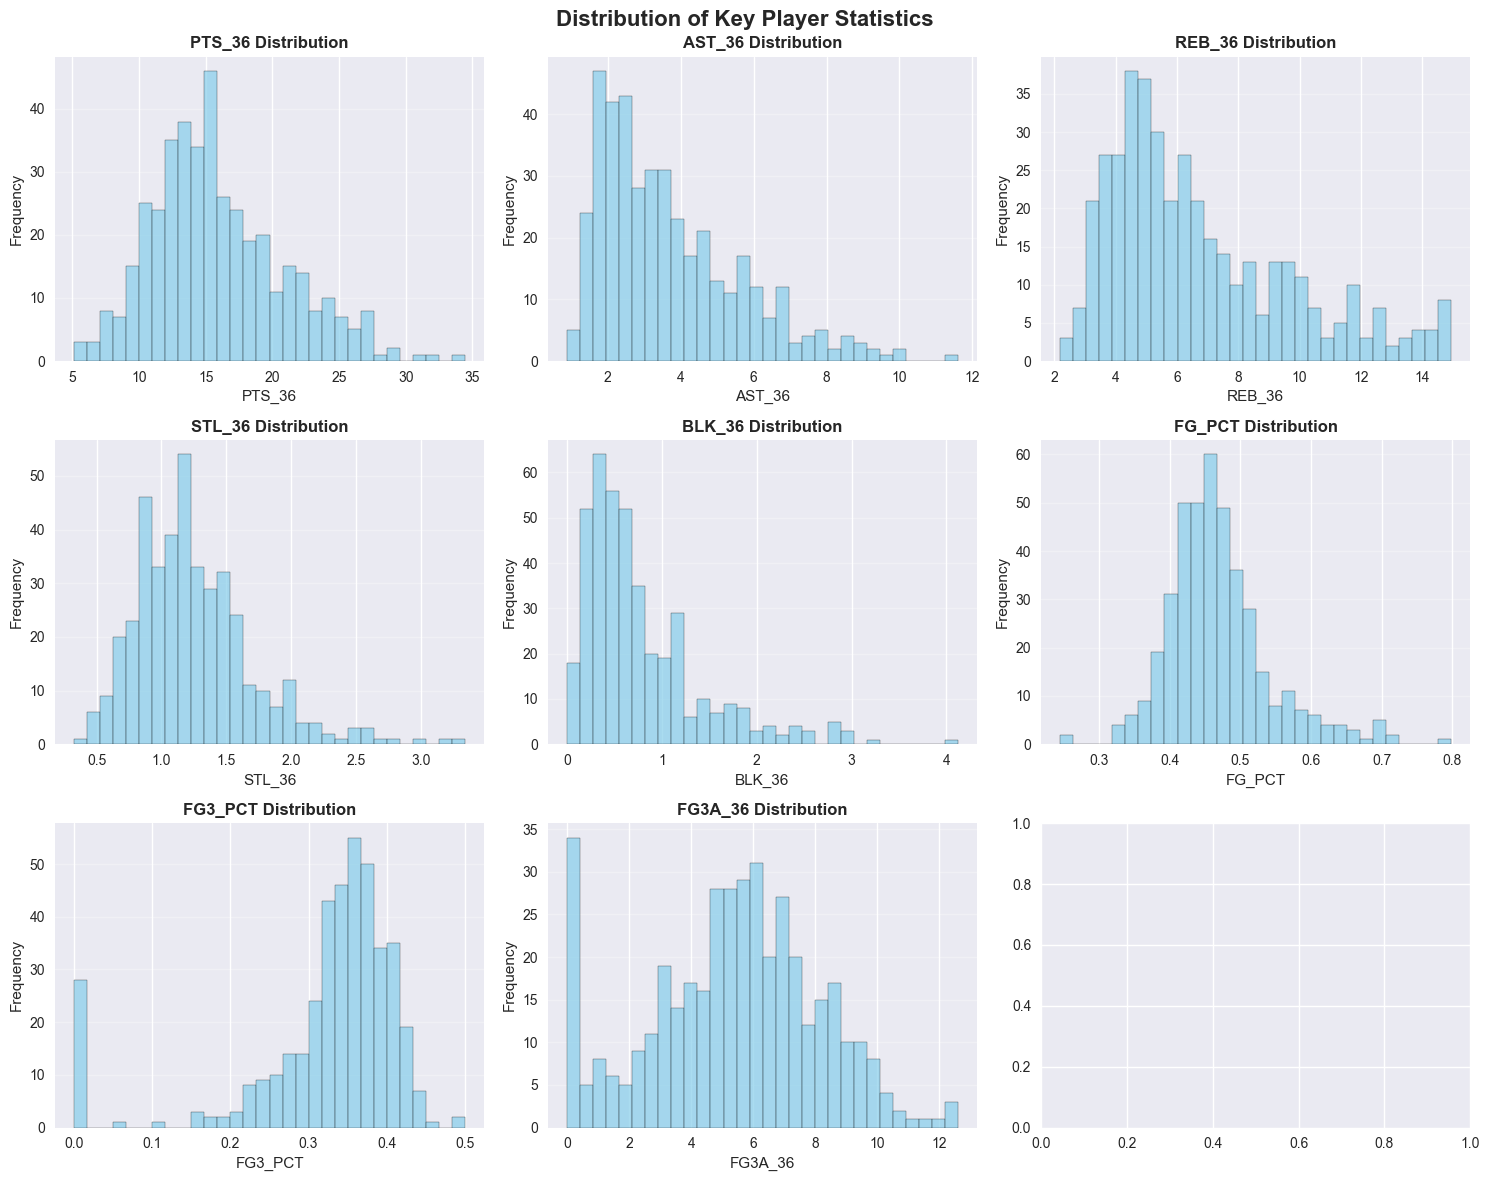

In [441]:
# Distribution plots for key features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Distribution of Key Player Statistics', fontsize=16, fontweight='bold')

key_features = ['PTS_36', 'AST_36', 'REB_36', 'STL_36', 'BLK_36', 'FG_PCT', 'FG3_PCT', 'FG3A_36']

for idx, feature in enumerate(key_features):
    row = idx // 3
    col = idx % 3
    
    axes[row, col].hist(df_work[feature], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[row, col].set_title(f'{feature} Distribution', fontweight='bold')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figures/01_feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

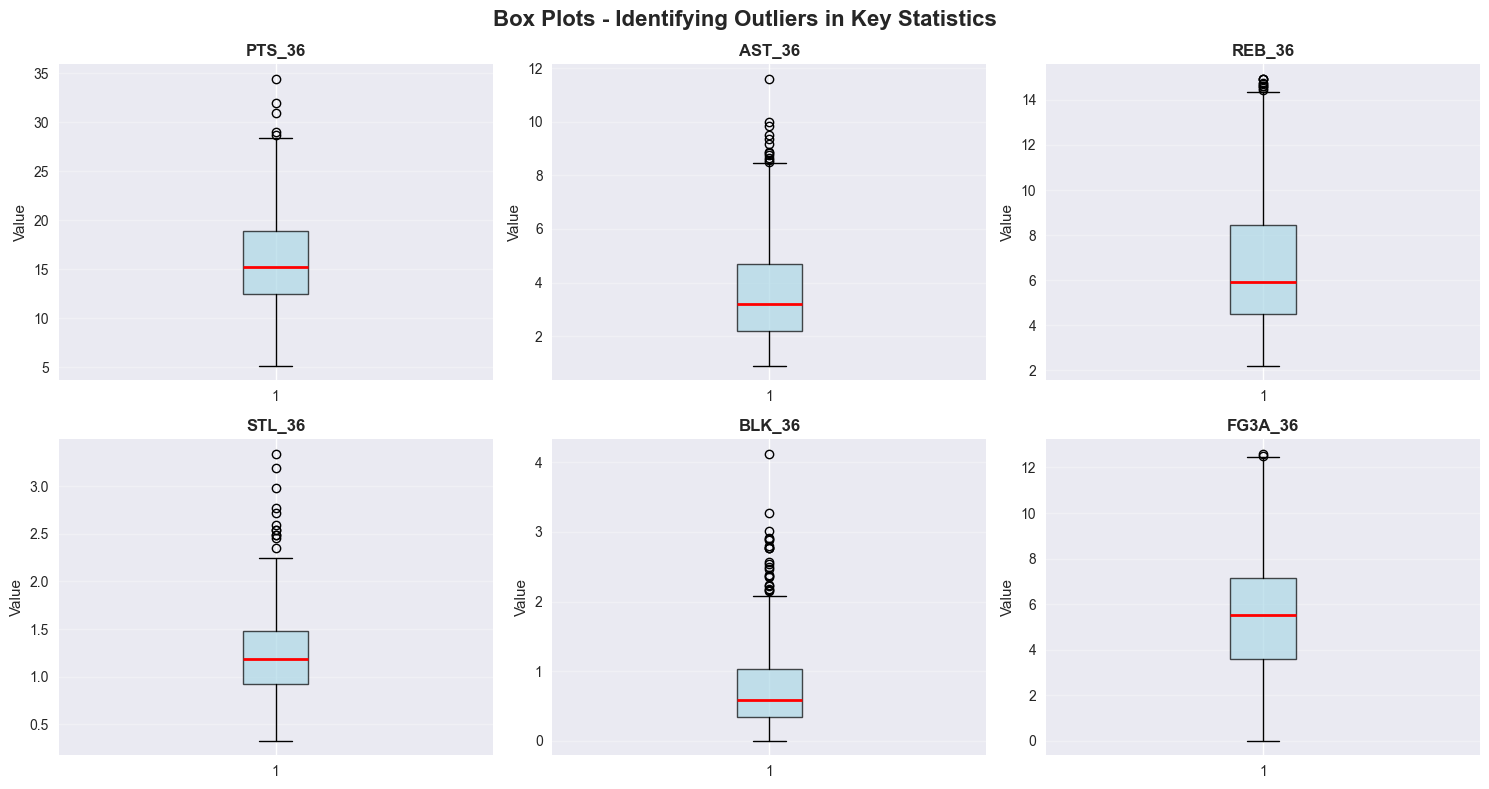

In [442]:
# Box plots to identify outliers
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Box Plots - Identifying Outliers in Key Statistics', fontsize=16, fontweight='bold')

box_features = ['PTS_36', 'AST_36', 'REB_36', 'STL_36', 'BLK_36', 'FG3A_36']

for idx, feature in enumerate(box_features):
    row = idx // 3
    col = idx % 3
    
    axes[row, col].boxplot(df_work[feature], vert=True, patch_artist=True,
                            boxprops=dict(facecolor='lightblue', alpha=0.7),
                            medianprops=dict(color='red', linewidth=2))
    axes[row, col].set_title(f'{feature}', fontweight='bold')
    axes[row, col].set_ylabel('Value')
    axes[row, col].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figures/02_feature_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.2 Bivariate Analysis - Correlation and Relationships

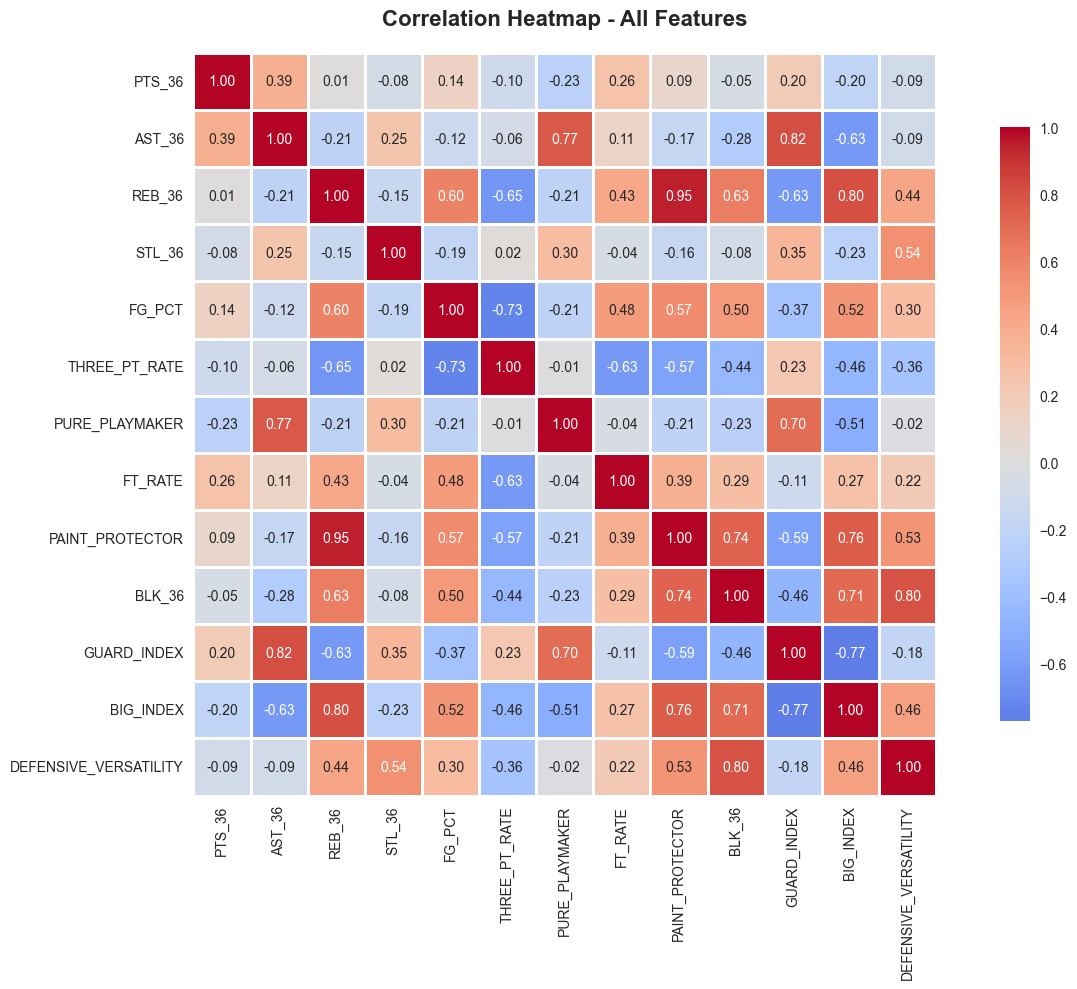


Highly Correlated Feature Pairs (|correlation| > 0.7):
AST_36 <-> PURE_PLAYMAKER: 0.767
AST_36 <-> GUARD_INDEX: 0.817
REB_36 <-> PAINT_PROTECTOR: 0.950
REB_36 <-> BIG_INDEX: 0.800
FG_PCT <-> THREE_PT_RATE: -0.734
PAINT_PROTECTOR <-> BLK_36: 0.737
PAINT_PROTECTOR <-> BIG_INDEX: 0.761
BLK_36 <-> BIG_INDEX: 0.713
BLK_36 <-> DEFENSIVE_VERSATILITY: 0.799
GUARD_INDEX <-> BIG_INDEX: -0.771


In [443]:
# Correlation heatmap
plt.figure(figsize=(14, 10))
correlation_matrix = df_work[feature_cols_enhanced].corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap - All Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('figures/03_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify highly correlated features
print("\nHighly Correlated Feature Pairs (|correlation| > 0.7):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            print(f"{correlation_matrix.columns[i]} <-> {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.3f}")

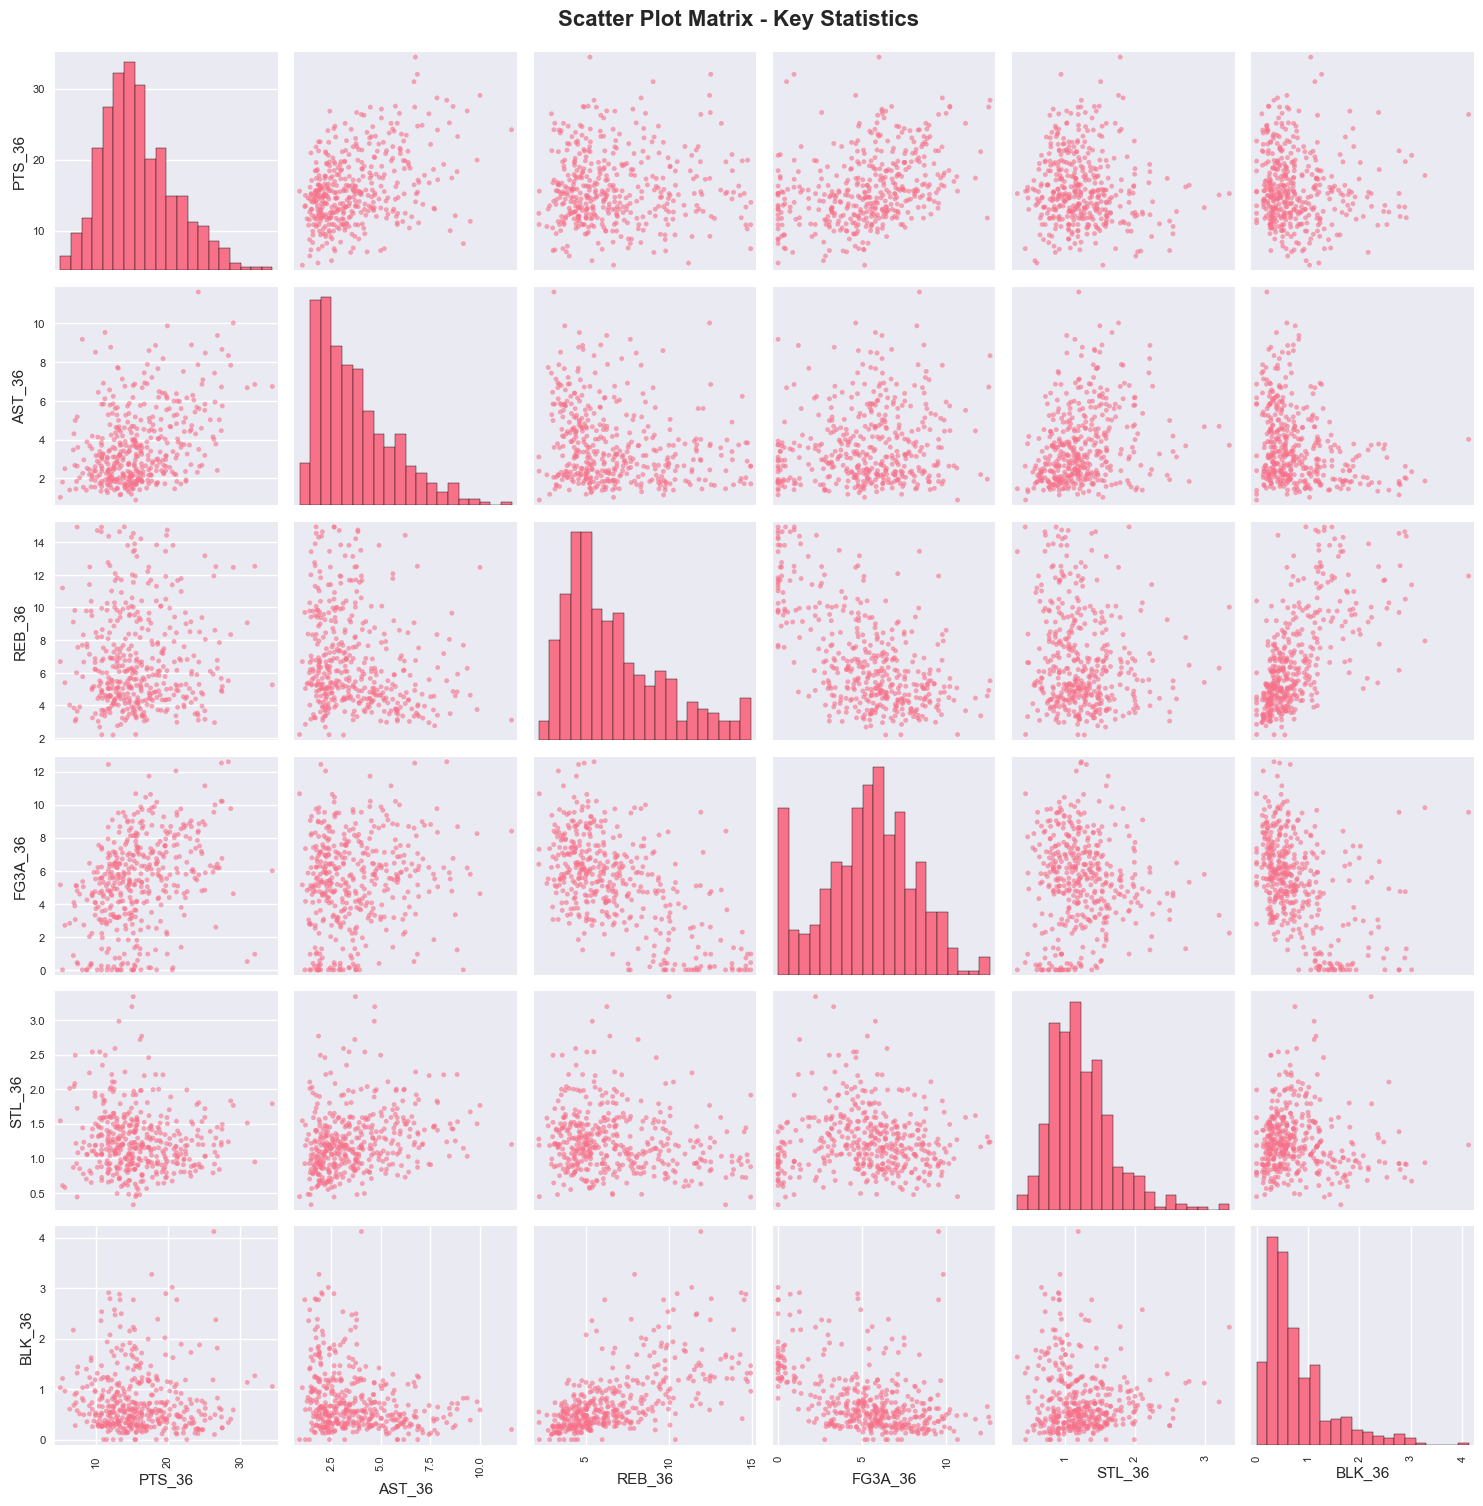

In [444]:
# Scatter plot matrix for key features
key_scatter_features = ['PTS_36', 'AST_36', 'REB_36', 'FG3A_36', 'STL_36', 'BLK_36']

scatter_matrix_df = df_work[key_scatter_features]
pd.plotting.scatter_matrix(scatter_matrix_df, figsize=(15, 15), diagonal='hist', 
                          alpha=0.6, hist_kwds={'bins': 20, 'edgecolor': 'black'})
plt.suptitle('Scatter Plot Matrix - Key Statistics', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [445]:
# Interactive scatter plot using Plotly
fig = px.scatter(df_work, x='PTS', y='AST', size='MIN', 
                 hover_name='PLAYER_NAME',
                 hover_data=['REB', 'FG3A', 'STL', 'BLK'],
                 title='Points vs Assists (Size = Minutes Played)',
                 labels={'PTS': 'Points Per Game', 'AST': 'Assists Per Game'},
                 color='REB',
                 color_continuous_scale='Viridis')

fig.update_layout(width=900, height=600)
fig.show()

In [446]:
# 3-Point Shooting Analysis
fig = px.scatter(df_work, x='FG3A', y='FG3_PCT', size='PTS',
                 hover_name='PLAYER_NAME',
                 title='Three-Point Shooting: Volume vs Efficiency',
                 labels={'FG3A': '3-Point Attempts Per Game', 
                        'FG3_PCT': '3-Point Shooting Percentage'},
                 color='THREE_PT_RATE',
                 color_continuous_scale='RdYlGn')

fig.update_layout(width=900, height=600)
fig.show()

### 3.3 Multivariate Analysis - Principal Component Analysis (PCA)

In [447]:
# Prepare data for PCA (standardize first)

X = df_work[feature_cols_enhanced].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(X_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"Number of components: {len(explained_variance)}")
print(f"\nVariance explained by first 5 components:")
for i in range(min(5, len(explained_variance))):
    print(f"PC{i+1}: {explained_variance[i]:.4f} ({cumulative_variance[i]:.4f} cumulative)")

Number of components: 13

Variance explained by first 5 components:
PC1: 0.4303 (0.4303 cumulative)
PC2: 0.1946 (0.6249 cumulative)
PC3: 0.1299 (0.7548 cumulative)
PC4: 0.0791 (0.8338 cumulative)
PC5: 0.0579 (0.8917 cumulative)


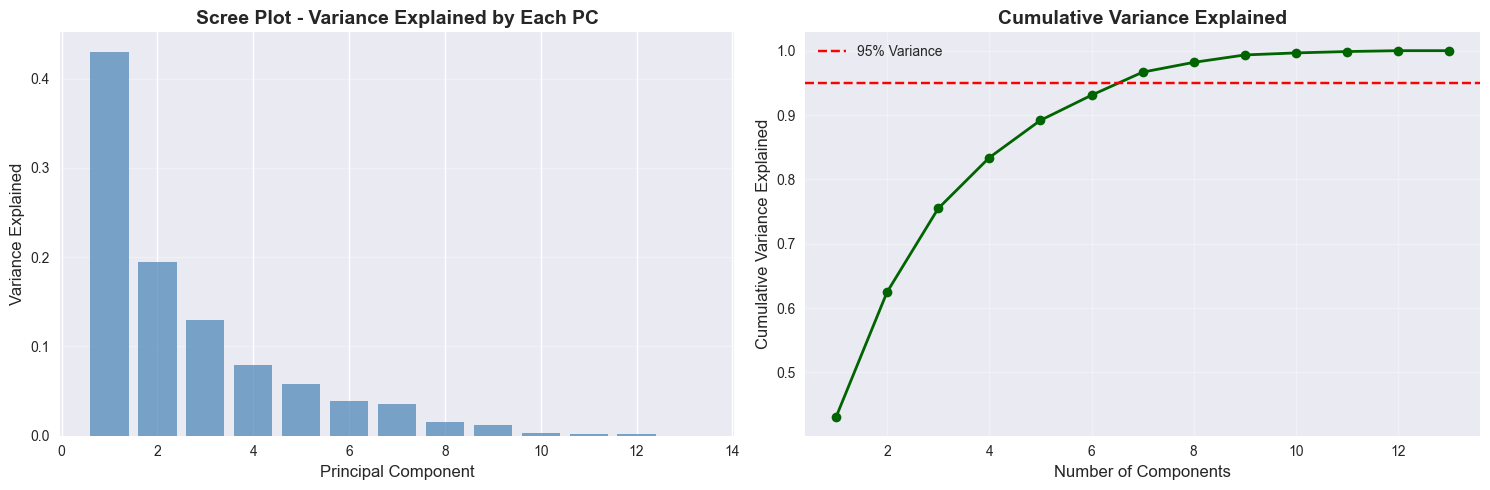


Number of components needed for 95% variance: 7


In [448]:
# Scree plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Variance explained
ax1.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.7, color='steelblue')
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Variance Explained', fontsize=12)
ax1.set_title('Scree Plot - Variance Explained by Each PC', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Cumulative variance
ax2.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 
         marker='o', linestyle='-', color='darkgreen', linewidth=2)
ax2.axhline(y=0.95, color='red', linestyle='--', label='95% Variance')
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('Cumulative Variance Explained', fontsize=12)
ax2.set_title('Cumulative Variance Explained', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figures/04_pca_scree_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nNumber of components needed for 95% variance: {n_components_95}")

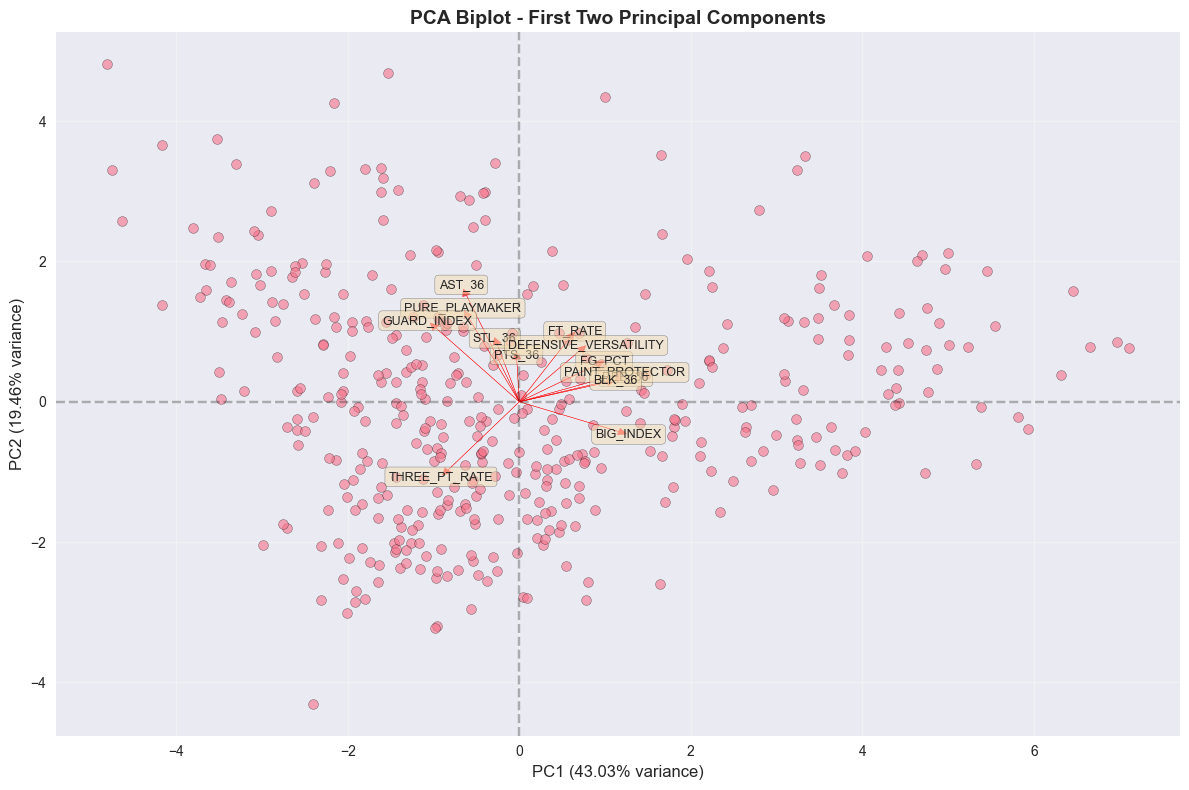

In [449]:
# PCA Biplot - First two components
plt.figure(figsize=(12, 8))

# Scatter plot of first two PCs
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6, s=50, edgecolors='black')

# Add feature vectors
for i, feature in enumerate(feature_cols_enhanced):
    plt.arrow(0, 0, 
             pca.components_[0, i]*3, 
             pca.components_[1, i]*3,
             head_width=0.1, head_length=0.1, fc='red', ec='red', alpha=0.7)
    plt.text(pca.components_[0, i]*3.3, 
            pca.components_[1, i]*3.3, 
            feature, fontsize=9, ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variance)', fontsize=12)
plt.title('PCA Biplot - First Two Principal Components', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/05_pca_biplot.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.4 Identifying Top Performers

In [450]:
# Top players by various categories
print("TOP SCORERS:")
print(df_work.nlargest(10, 'PTS')[['PLAYER_NAME', 'PTS', 'FGA', 'FG_PCT']].to_string(index=False))

print("\n" + "="*60 + "\n")

print("TOP PLAYMAKERS:")
print(df_work.nlargest(10, 'AST')[['PLAYER_NAME', 'AST', 'AST_TO_RATIO', 'TOV']].to_string(index=False))

print("\n" + "="*60 + "\n")

print("TOP REBOUNDERS:")
print(df_work.nlargest(10, 'REB')[['PLAYER_NAME', 'REB', 'MIN']].to_string(index=False))

print("\n" + "="*60 + "\n")

print("TOP 3-POINT SHOOTERS (Volume):")
print(df_work.nlargest(10, 'FG3A')[['PLAYER_NAME', 'FG3A', 'FG3_PCT', 'THREE_PT_RATE']].to_string(index=False))

TOP SCORERS:
            PLAYER_NAME  PTS  FGA  FG_PCT
Shai Gilgeous-Alexander 32.7 21.8   0.519
  Giannis Antetokounmpo 30.4 19.7   0.601
           Nikola Jokić 29.6 19.5   0.576
            Luka Dončić 28.2 20.5   0.450
        Anthony Edwards 27.6 20.4   0.447
           Jayson Tatum 26.8 20.3   0.452
           Kevin Durant 26.6 18.1   0.527
           Tyrese Maxey 26.3 21.0   0.437
        Cade Cunningham 26.1 20.8   0.469
          Jalen Brunson 26.0 18.5   0.488


TOP PLAYMAKERS:
      PLAYER_NAME  AST  AST_TO_RATIO  TOV
       Trae Young 11.6      2.416667  4.7
     Nikola Jokić 10.2      3.000000  3.3
Tyrese Haliburton  9.2      5.411765  1.6
  Cade Cunningham  9.1      2.022222  4.4
     James Harden  8.7      1.977273  4.3
     LeBron James  8.2      2.157895  3.7
      Luka Dončić  7.7      2.081081  3.6
       Chris Paul  7.4      4.352941  1.6
  Dejounte Murray  7.4      2.114286  3.4
      LaMelo Ball  7.4      2.000000  3.6


TOP REBOUNDERS:
          PLAYER_NAME  REB 

---
## 4. Model Development & Training

### 4.1 Data Preparation for Clustering

In [451]:
# Prepare feature matrix
X_features = df_work[feature_cols_enhanced].values
player_names = df_work['PLAYER_NAME'].values

print(f"Feature matrix shape: {X_features.shape}")
print(f"Number of players: {len(player_names)}")
print(f"Number of features: {X_features.shape[1]}")

Feature matrix shape: (411, 13)
Number of players: 411
Number of features: 13


In [452]:
# Feature Extraction
X_features = df_work[feature_cols_enhanced].values
player_names = df_work['PLAYER_NAME'].values

print(f"Feature matrix shape: {X_features.shape}")
print(f"Number of players: {len(player_names)}")
print(f"Number of features: {X_features.shape[1]}")

# Feature scaling using RobustScaler - better handles outliers than StandardScaler
# RobustScaler uses median and IQR instead of mean and std, making it robust to extreme values
from sklearn.preprocessing import RobustScaler
scaler_final = RobustScaler()
X_scaled_final = scaler_final.fit_transform(X_features)

print("\nFeatures scaled using RobustScaler (robust to outliers)")
print(f"Scaled data shape: {X_scaled_final.shape}")
print(f"Median of scaled features: {np.median(X_scaled_final):.6f}")
print(f"IQR of scaled features: {np.percentile(X_scaled_final, 75) - np.percentile(X_scaled_final, 25):.6f}")

Feature matrix shape: (411, 13)
Number of players: 411
Number of features: 13

Features scaled using RobustScaler (robust to outliers)
Scaled data shape: (411, 13)
Median of scaled features: 0.000000
IQR of scaled features: 0.985111


### 4.2 K-Means Clustering

#### 4.2.1 Determining Optimal Number of Clusters

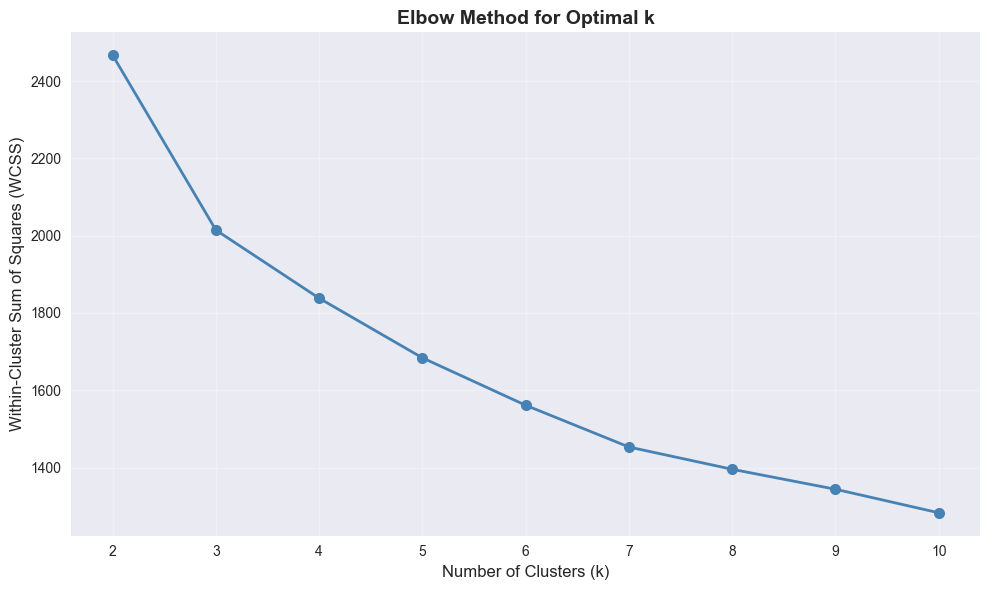

In [453]:
# Elbow Method - Within-Cluster Sum of Squares (WCSS)
wcss = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans.fit(X_scaled_final)
    wcss.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o', linestyle='-', linewidth=2, markersize=8, color='steelblue')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.xticks(K_range)
plt.tight_layout()
plt.savefig('figures/06_elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

k=2: Silhouette Score = 0.3358
k=3: Silhouette Score = 0.2421
k=4: Silhouette Score = 0.2110
k=5: Silhouette Score = 0.1967
k=6: Silhouette Score = 0.1823
k=7: Silhouette Score = 0.1898
k=8: Silhouette Score = 0.1692
k=9: Silhouette Score = 0.1580
k=10: Silhouette Score = 0.1465


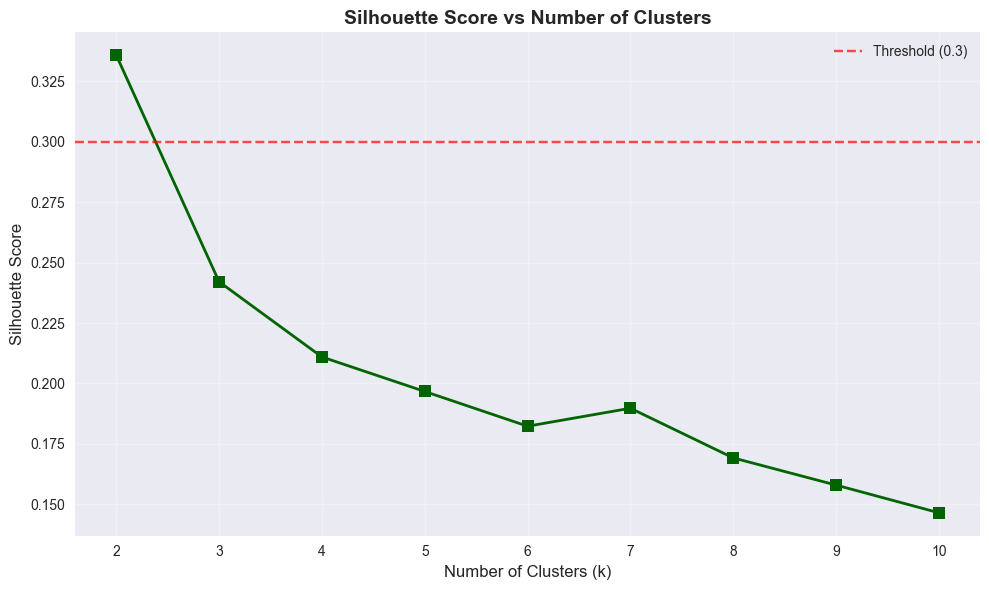


Optimal k based on Silhouette Score: 2


In [454]:
# Silhouette Score Analysis
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled_final)
    silhouette_avg = silhouette_score(X_scaled_final, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"k={k}: Silhouette Score = {silhouette_avg:.4f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='s', linestyle='-', linewidth=2, markersize=8, color='darkgreen')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.xticks(K_range)
plt.axhline(y=0.3, color='red', linestyle='--', label='Threshold (0.3)', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('figures/07_silhouette_scores.png', dpi=300, bbox_inches='tight')
plt.show()

# Find optimal k
optimal_k_silhouette = K_range[np.argmax(silhouette_scores)]
print(f"\nOptimal k based on Silhouette Score: {optimal_k_silhouette}")

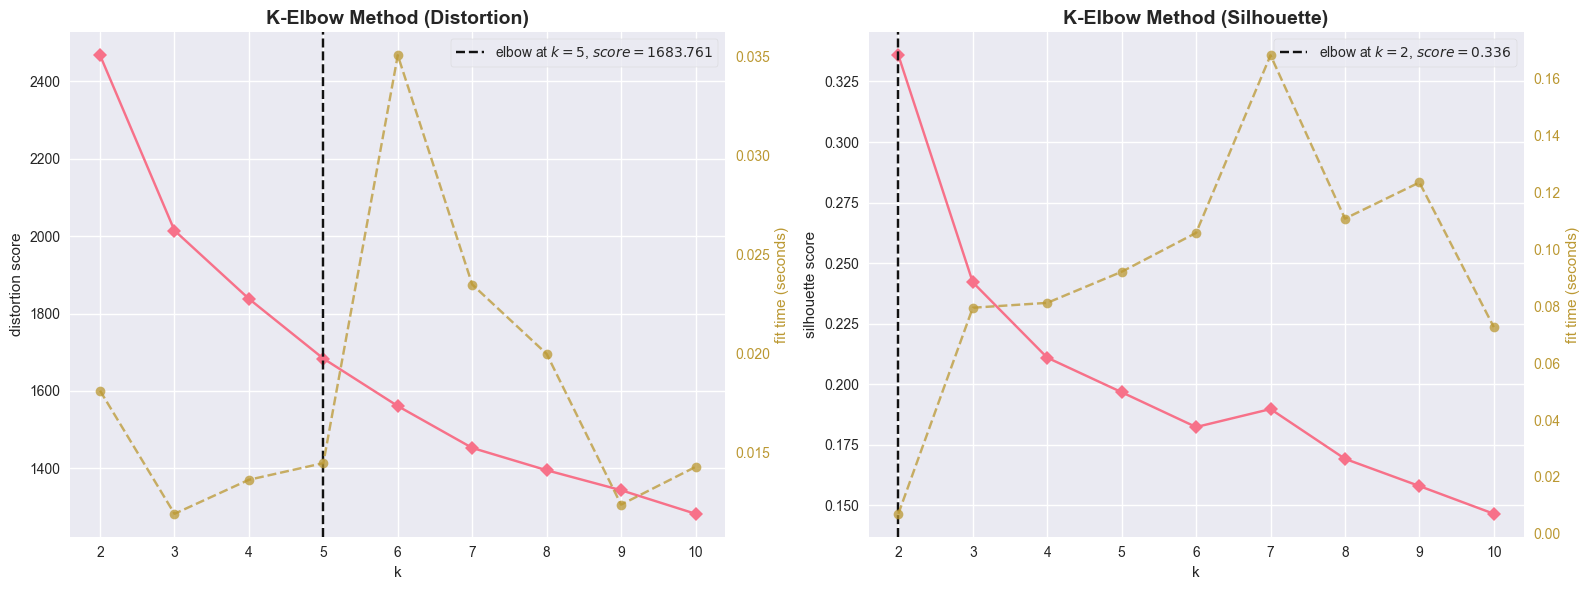

In [455]:
# Yellowbrick Elbow Visualizer

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Distortion score elbow
model = KMeans(random_state=RANDOM_STATE, n_init=10)
visualizer1 = KElbowVisualizer(model, k=(2, 11), metric='distortion', ax=ax1)
visualizer1.fit(X_scaled_final)
visualizer1.finalize()
ax1.set_title('K-Elbow Method (Distortion)', fontsize=14, fontweight='bold')

# Silhouette score elbow
model = KMeans(random_state=RANDOM_STATE, n_init=10)
visualizer2 = KElbowVisualizer(model, k=(2, 11), metric='silhouette', ax=ax2)
visualizer2.fit(X_scaled_final)
visualizer2.finalize()
ax2.set_title('K-Elbow Method (Silhouette)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/08_kelbow_visualizer.png', dpi=300, bbox_inches='tight')
plt.show()

#### 4.2.2 Train Final K-Means Model

In [456]:
# ============================================================================
# SMART K SELECTION WITH MULTIPLE STRATEGIES
# ============================================================================

MIN_CLUSTERS = 5  # Basketball requires at least 5 distinct roles

print("Clustering Strategy Selection:")
print("=" * 80)

# Strategy 1: If silhouette suggests k >= 5, use it
if optimal_k_silhouette >= MIN_CLUSTERS:
    OPTIMAL_K = optimal_k_silhouette
    CLUSTERING_METHOD = 'kmeans'
    print(f"✓ Using K-Means with data-driven k={OPTIMAL_K}")
    print(f"  Silhouette score: {silhouette_scores[OPTIMAL_K-2]:.4f}")

# Strategy 2: If silhouette suggests k < 5, try GMM instead
else:
    print(f"⚠ K-Means suggests k={optimal_k_silhouette} (below minimum {MIN_CLUSTERS})")
    print(f"  This indicates overlapping clusters - better suited for GMM")
    print(f"\n→ Switching to Gaussian Mixture Model with k={MIN_CLUSTERS}")
    print(f"  GMM handles overlapping/fuzzy clusters better than K-Means")
    
    OPTIMAL_K = MIN_CLUSTERS
    CLUSTERING_METHOD = 'gmm'

print(f"\nFinal selection: {CLUSTERING_METHOD.upper()} with k={OPTIMAL_K}")
print("=" * 80)

# Apply selected clustering method
if CLUSTERING_METHOD == 'kmeans':
    # Standard K-Means
    from sklearn.cluster import KMeans
    model_final = KMeans(n_clusters=OPTIMAL_K, random_state=RANDOM_STATE, n_init=20)
    cluster_labels = model_final.fit_predict(X_scaled_final)
    
elif CLUSTERING_METHOD == 'gmm':
    # Gaussian Mixture Model (better for overlapping clusters)
    from sklearn.mixture import GaussianMixture
    model_final = GaussianMixture(n_components=OPTIMAL_K, random_state=RANDOM_STATE, 
                                  n_init=10, covariance_type='full')
    cluster_labels = model_final.fit_predict(X_scaled_final)
    print(f"\nGMM trained - allows soft cluster membership")
    print(f"Players can be 'between' archetypes (realistic for modern NBA)")

# Add cluster labels to dataframe
df_work['Final_Cluster'] = cluster_labels

# Evaluate clustering quality
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
final_silhouette = silhouette_score(X_scaled_final, cluster_labels)
final_calinski = calinski_harabasz_score(X_scaled_final, cluster_labels)
final_davies = davies_bouldin_score(X_scaled_final, cluster_labels)

print(f"\nClustering Quality Metrics:")
print(f"  Silhouette Score: {final_silhouette:.4f} (>0.25 acceptable, >0.5 good)")
print(f"  Calinski-Harabasz: {final_calinski:.2f} (higher is better)")
print(f"  Davies-Bouldin: {final_davies:.4f} (lower is better)")

print(f"\nCluster distribution:")
print(df_work['Final_Cluster'].value_counts().sort_index())

# Note on interpretation
if final_silhouette < 0.25:
    print(f"\n⚠ Note: Silhouette score {final_silhouette:.3f} indicates significant overlap")
    print(f"  This is EXPECTED for modern NBA - players have versatile, overlapping roles")
    print(f"  Clusters still valid if they're interpretable (check archetype naming)")

Clustering Strategy Selection:
⚠ K-Means suggests k=2 (below minimum 5)
  This indicates overlapping clusters - better suited for GMM

→ Switching to Gaussian Mixture Model with k=5
  GMM handles overlapping/fuzzy clusters better than K-Means

Final selection: GMM with k=5

GMM trained - allows soft cluster membership
Players can be 'between' archetypes (realistic for modern NBA)

Clustering Quality Metrics:
  Silhouette Score: 0.0838 (>0.25 acceptable, >0.5 good)
  Calinski-Harabasz: 80.88 (higher is better)
  Davies-Bouldin: 2.2662 (lower is better)

Cluster distribution:
Final_Cluster
0     68
1     91
2    106
3     89
4     57
Name: count, dtype: int64

⚠ Note: Silhouette score 0.084 indicates significant overlap
  This is EXPECTED for modern NBA - players have versatile, overlapping roles
  Clusters still valid if they're interpretable (check archetype naming)


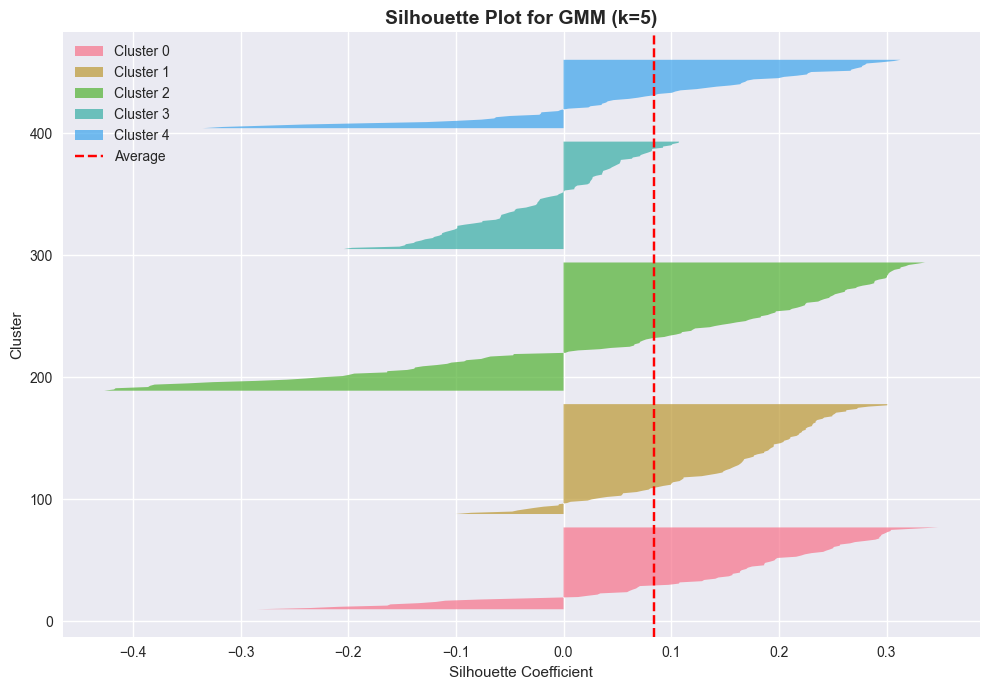

Silhouette plot created for GMM with k=5


In [457]:
# Detailed Silhouette Plot for Final Model

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Use appropriate model based on clustering method
if CLUSTERING_METHOD == 'kmeans':
    visualizer = SilhouetteVisualizer(model_final, colors='yellowbrick', ax=ax)
    visualizer.fit(X_scaled_final)
    visualizer.finalize()
    plt.title(f'Silhouette Plot for K-Means (k={OPTIMAL_K})', fontsize=14, fontweight='bold')
else:
    # For GMM, manually create silhouette plot
    from sklearn.metrics import silhouette_samples
    cluster_labels = df_work['Final_Cluster'].values
    silhouette_vals = silhouette_samples(X_scaled_final, cluster_labels)
    
    y_lower = 10
    for i in range(OPTIMAL_K):
        cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        cluster_silhouette_vals.sort()
        
        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                        alpha=0.7, label=f'Cluster {i}')
        y_lower = y_upper + 10
    
    ax.set_xlabel('Silhouette Coefficient')
    ax.set_ylabel('Cluster')
    ax.set_title(f'Silhouette Plot for GMM (k={OPTIMAL_K})', fontsize=14, fontweight='bold')
    ax.axvline(x=final_silhouette, color='red', linestyle='--', label='Average')
    ax.legend()

plt.tight_layout()
plt.savefig('figures/09_silhouette_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Silhouette plot created for {CLUSTERING_METHOD.upper()} with k={OPTIMAL_K}")

### 4.3 Hierarchical Clustering

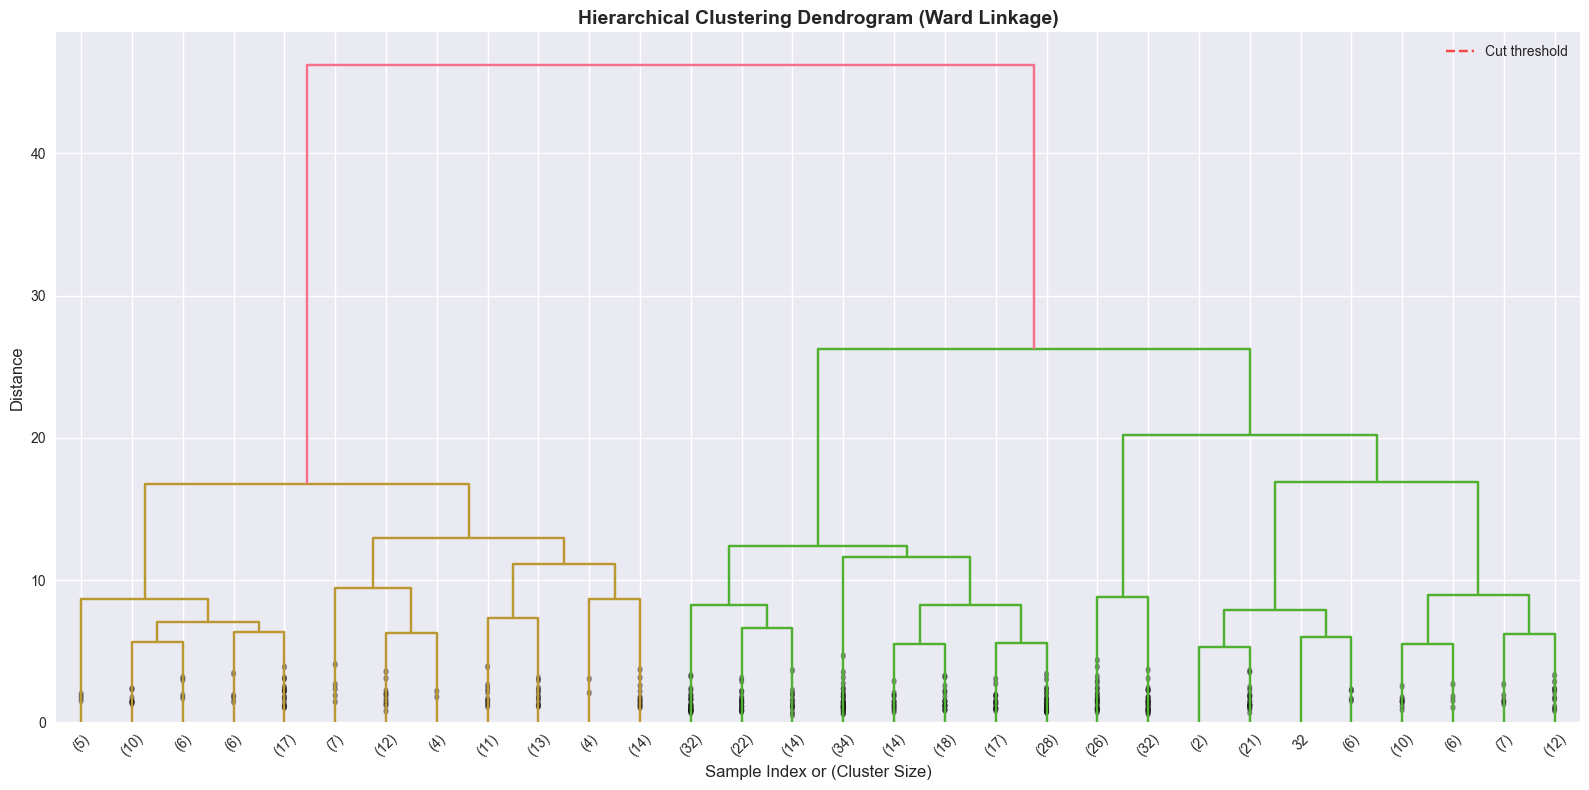

In [458]:
# Compute linkage matrix
# Using Ward's method (minimizes within-cluster variance)
linkage_matrix = linkage(X_scaled_final, method='ward')

# Plot dendrogram
plt.figure(figsize=(16, 8))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30, 
           leaf_font_size=10, show_contracted=True)
plt.xlabel('Sample Index or (Cluster Size)', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)', fontsize=14, fontweight='bold')
plt.axhline(y=50, color='red', linestyle='--', label='Cut threshold', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

### 4.4 DBSCAN Clustering

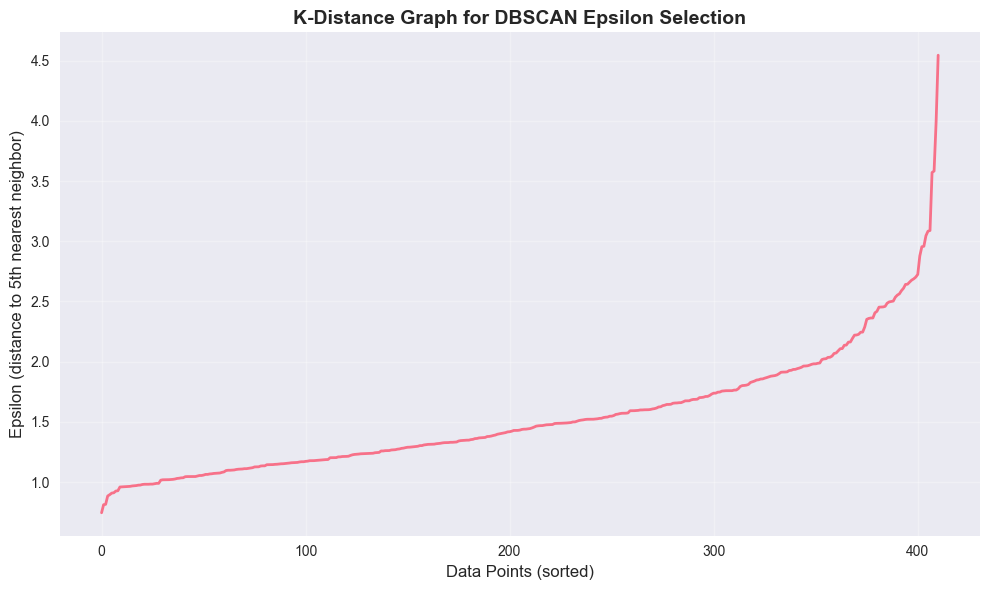

Look for the 'elbow' in the k-distance graph to select epsilon


In [459]:
# Find optimal epsilon using k-distance graph

# Calculate distances to k-nearest neighbors
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled_final)
distances, indices = neighbors_fit.kneighbors(X_scaled_final)

# Sort and plot distances
distances = np.sort(distances[:, -1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances, linewidth=2)
plt.xlabel('Data Points (sorted)', fontsize=12)
plt.ylabel('Epsilon (distance to 5th nearest neighbor)', fontsize=12)
plt.title('K-Distance Graph for DBSCAN Epsilon Selection', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Look for the 'elbow' in the k-distance graph to select epsilon")

In [460]:
# Apply DBSCAN with selected parameters
# Adjust eps and min_samples based on k-distance graph
dbscan_model = DBSCAN(eps=3.0, min_samples=5)
dbscan_labels = dbscan_model.fit_predict(X_scaled_final)

# Add to dataframe
df_work['DBSCAN_Cluster'] = dbscan_labels

# Count clusters and noise points
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN clustering complete")
print(f"Number of clusters: {n_clusters_dbscan}")
print(f"Number of noise points (outliers): {n_noise}")
print(f"\nCluster distribution:")
print(df_work['DBSCAN_Cluster'].value_counts().sort_index())

# Silhouette score (excluding noise points)
if n_clusters_dbscan > 1:
    mask = dbscan_labels != -1
    if sum(mask) > 0:
        dbscan_silhouette = silhouette_score(X_scaled_final[mask], dbscan_labels[mask])
        print(f"\nSilhouette Score (excluding noise): {dbscan_silhouette:.4f}")

DBSCAN clustering complete
Number of clusters: 1
Number of noise points (outliers): 2

Cluster distribution:
DBSCAN_Cluster
-1      2
 0    409
Name: count, dtype: int64


In [461]:
# Identify outlier players (noise points)
if n_noise > 0:
    print("Outlier Players (DBSCAN Noise Points):")
    outlier_players = df_work[df_work['DBSCAN_Cluster'] == -1][['PLAYER_NAME', 'PTS', 'AST', 'REB']]
    print(outlier_players.to_string(index=False))

Outlier Players (DBSCAN Noise Points):
      PLAYER_NAME  PTS  AST  REB
      Ben Simmons  5.0  5.6  4.7
Victor Wembanyama 24.3  3.7 11.0


### 4.5 Gaussian Mixture Models (GMM)

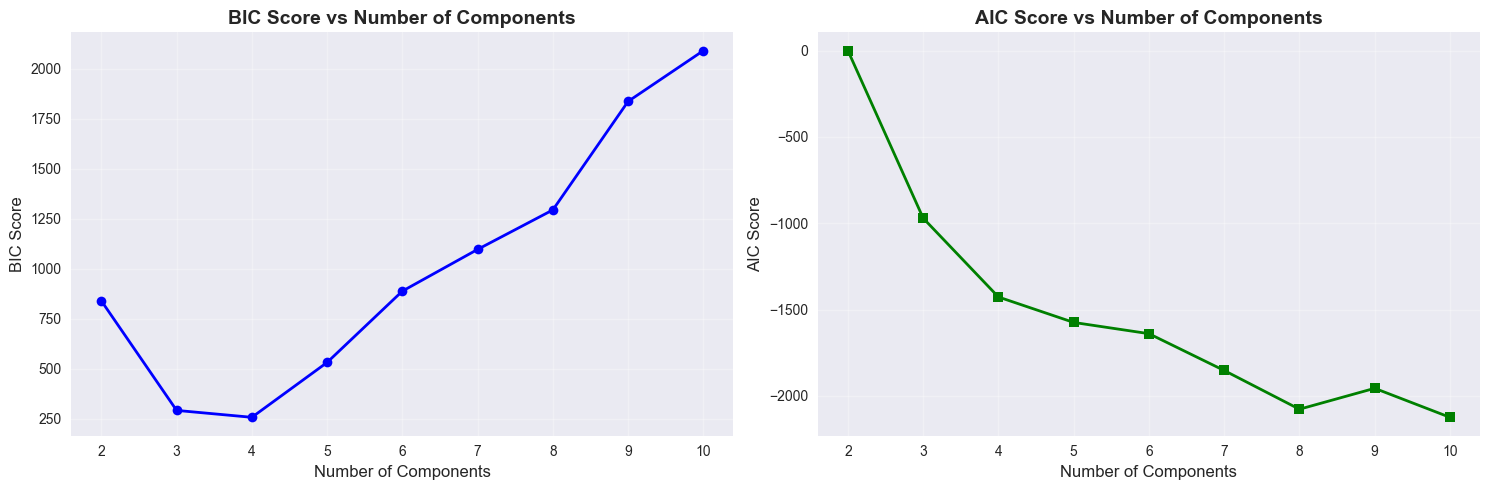

Optimal components based on BIC: 4
Optimal components based on AIC: 10


In [462]:
# BIC and AIC for selecting optimal number of components
n_components_range = range(2, 11)
bic_scores = []
aic_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=RANDOM_STATE, n_init=10)
    gmm.fit(X_scaled_final)
    bic_scores.append(gmm.bic(X_scaled_final))
    aic_scores.append(gmm.aic(X_scaled_final))

# Plot BIC and AIC
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(n_components_range, bic_scores, marker='o', linestyle='-', linewidth=2, color='blue')
ax1.set_xlabel('Number of Components', fontsize=12)
ax1.set_ylabel('BIC Score', fontsize=12)
ax1.set_title('BIC Score vs Number of Components', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

ax2.plot(n_components_range, aic_scores, marker='s', linestyle='-', linewidth=2, color='green')
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('AIC Score', fontsize=12)
ax2.set_title('AIC Score vs Number of Components', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Optimal components (lowest BIC/AIC)
optimal_components_bic = n_components_range[np.argmin(bic_scores)]
optimal_components_aic = n_components_range[np.argmin(aic_scores)]

print(f"Optimal components based on BIC: {optimal_components_bic}")
print(f"Optimal components based on AIC: {optimal_components_aic}")

### 4.6 Model Comparison and Selection

In [463]:
# Comprehensive evaluation metrics for final selected model

print("Model Evaluation:")
print("=" * 80)
print(f"Selected method: {CLUSTERING_METHOD.upper()}")
print(f"Number of clusters: {OPTIMAL_K}")
print(f"\nQuality Metrics:")
print(f"  Silhouette Score: {final_silhouette:.4f}")
print(f"  Calinski-Harabasz: {final_calinski:.2f}")
print(f"  Davies-Bouldin: {final_davies:.4f}")

# If other algorithms were also run (cells 44, 47, 51), compare them
# Otherwise just show the final model metrics
try:
    # Try to compare if other models exist
    algorithms = []
    labels_list = []
    
    # Always have the final model
    algorithms.append(CLUSTERING_METHOD.upper())
    labels_list.append(df_work['Final_Cluster'].values)
    
    # Add other models if they were run
    if 'hierarchical_labels' in locals():
        algorithms.append('Hierarchical')
        labels_list.append(hierarchical_labels)
    
    if 'gmm_labels' in locals() and CLUSTERING_METHOD != 'gmm':
        algorithms.append('GMM')
        labels_list.append(gmm_labels)
    
    if len(algorithms) > 1:
        print(f"\nComparison with other algorithms:")
        print("=" * 80)
        
        results = []
        for algo_name, labels in zip(algorithms, labels_list):
            from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
            silhouette = silhouette_score(X_scaled_final, labels)
            calinski = calinski_harabasz_score(X_scaled_final, labels)
            davies = davies_bouldin_score(X_scaled_final, labels)
            
            results.append({
                'Algorithm': algo_name,
                'Silhouette Score': silhouette,
                'Calinski-Harabasz': calinski,
                'Davies-Bouldin': davies,
                'N_Clusters': OPTIMAL_K
            })
        
        results_df = pd.DataFrame(results)
        print(results_df.to_string(index=False))
        
        print("\nInterpretation:")
        print("- Silhouette Score: Higher is better (range: -1 to 1, >0.25 acceptable)")
        print("- Calinski-Harabasz: Higher is better (measures cluster separation)")
        print("- Davies-Bouldin: Lower is better (measures cluster similarity)")
    
except NameError:
    # Other models weren't run, just show final model
    print("\n(Only final model was evaluated)")

Model Evaluation:
Selected method: GMM
Number of clusters: 5

Quality Metrics:
  Silhouette Score: 0.0838
  Calinski-Harabasz: 80.88
  Davies-Bouldin: 2.2662

Comparison with other algorithms:
   Algorithm  Silhouette Score  Calinski-Harabasz  Davies-Bouldin  N_Clusters
         GMM          0.083825          80.883563        2.266241           5
Hierarchical          0.158972          93.981194        1.619643           5

Interpretation:
- Silhouette Score: Higher is better (range: -1 to 1, >0.25 acceptable)
- Calinski-Harabasz: Higher is better (measures cluster separation)
- Davies-Bouldin: Lower is better (measures cluster similarity)


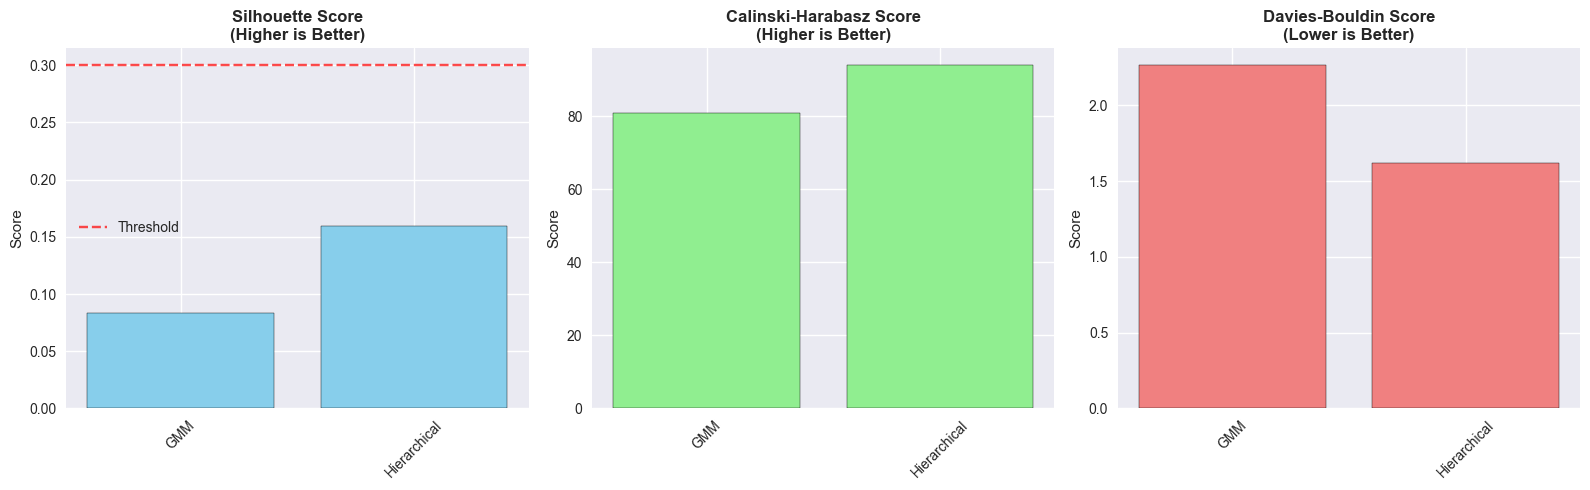

In [464]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Silhouette Score
axes[0].bar(results_df['Algorithm'], results_df['Silhouette Score'], color='skyblue', edgecolor='black')
axes[0].set_ylabel('Score', fontsize=11)
axes[0].set_title('Silhouette Score\n(Higher is Better)', fontsize=12, fontweight='bold')
axes[0].axhline(y=0.3, color='red', linestyle='--', alpha=0.7, label='Threshold')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Calinski-Harabasz
axes[1].bar(results_df['Algorithm'], results_df['Calinski-Harabasz'], color='lightgreen', edgecolor='black')
axes[1].set_ylabel('Score', fontsize=11)
axes[1].set_title('Calinski-Harabasz Score\n(Higher is Better)', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

# Davies-Bouldin
axes[2].bar(results_df['Algorithm'], results_df['Davies-Bouldin'], color='lightcoral', edgecolor='black')
axes[2].set_ylabel('Score', fontsize=11)
axes[2].set_title('Davies-Bouldin Score\n(Lower is Better)', fontsize=12, fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [465]:
# Verify Final_Cluster was created by Cell 40

print(f"Clustering method used: {CLUSTERING_METHOD.upper()}")
print(f"Number of clusters: {OPTIMAL_K}")
print(f"\nFinal cluster distribution:")
print(df_work['Final_Cluster'].value_counts().sort_index())

# Verify no missing cluster assignments
if df_work['Final_Cluster'].isna().any():
    print("\n⚠ Warning: Some players not assigned to clusters")
else:
    print(f"\n✓ All {len(df_work)} players successfully assigned to clusters")

Clustering method used: GMM
Number of clusters: 5

Final cluster distribution:
Final_Cluster
0     68
1     91
2    106
3     89
4     57
Name: count, dtype: int64

✓ All 411 players successfully assigned to clusters


---
## 5. Results & Interpretation

### 5.1 Cluster Statistical Profiles

In [466]:
# Calculate mean statistics for each cluster
cluster_profiles = df_work.groupby('Final_Cluster')[feature_cols_enhanced].mean()

print("Cluster Statistical Profiles (Mean Values):")
print("=" * 100)
print(cluster_profiles.round(2).to_string())

Cluster Statistical Profiles (Mean Values):
               PTS_36  AST_36  REB_36  STL_36  FG_PCT  THREE_PT_RATE  PURE_PLAYMAKER  FT_RATE  PAINT_PROTECTOR  BLK_36  GUARD_INDEX  BIG_INDEX  DEFENSIVE_VERSATILITY
Final_Cluster                                                                                                                                                        
0               22.29    5.80    5.25    1.30    0.46           0.41            0.25     0.27             4.80    0.47         1.18       0.85                   1.77
1               14.86    3.06    4.92    1.16    0.44           0.54            0.20     0.19             4.21    0.46         0.71       1.34                   1.62
2               15.26    2.53   10.52    1.07    0.54           0.24            0.17     0.30             8.65    1.53         0.32       3.58                   2.60
3               14.64    2.65    6.83    1.27    0.46           0.48            0.18     0.22             5.76    0.67        

In [467]:
# Create a more detailed profile table
detailed_profiles = []

for cluster_id in sorted(df_work['Final_Cluster'].unique()):
    cluster_data = df_work[df_work['Final_Cluster'] == cluster_id]
    
    profile = {
        'Cluster': cluster_id,
        'Size': len(cluster_data),
        'Avg_PTS_36': cluster_data['PTS_36'].mean(),
        'Avg_AST_36': cluster_data['AST_36'].mean(),
        'Avg_REB': cluster_data['REB'].mean(),
        'Avg_3PA': cluster_data['FG3A'].mean(),
        'Avg_3P%': cluster_data['FG3_PCT'].mean(),
        'Avg_STL': cluster_data['STL'].mean(),
        'Avg_BLK': cluster_data['BLK'].mean(),
        'Avg_MIN': cluster_data['MIN'].mean()
    }
    detailed_profiles.append(profile)

profiles_df = pd.DataFrame(detailed_profiles)
print("\nDetailed Cluster Profiles:")
print(profiles_df.round(2).to_string(index=False))


Detailed Cluster Profiles:
 Cluster  Size  Avg_PTS_36  Avg_AST_36  Avg_REB  Avg_3PA  Avg_3P%  Avg_STL  Avg_BLK  Avg_MIN
       0    68       22.29        5.80     4.42     5.87     0.36     1.06     0.39    29.77
       1    91       14.86        3.06     3.13     4.13     0.36     0.73     0.29    22.55
       2   106       15.26        2.53     5.83     1.67     0.24     0.58     0.84    19.63
       3    89       14.64        2.65     4.02     3.14     0.34     0.71     0.39    20.84
       4    57       13.39        6.02     2.52     3.34     0.34     0.96     0.28    21.32


### 5.2 Cluster Visualization

In [468]:
# PCA visualization with cluster colors
pca_vis = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca_vis.fit_transform(X_scaled_final)

# Add PCA components to dataframe
df_work['PCA1'] = X_pca[:, 0]
df_work['PCA2'] = X_pca[:, 1]

# Interactive scatter plot with Plotly
fig = px.scatter(df_work, x='PCA1', y='PCA2', color='Final_Cluster',
                 hover_name='PLAYER_NAME',
                 hover_data=['PTS_36', 'AST_36', 'REB_36', 'FG3A_36'],
                 title=f'Player Clusters Visualization (PCA) - {CLUSTERING_METHOD}',
                 labels={'PCA1': f'PC1 ({pca_vis.explained_variance_ratio_[0]:.1%} variance)',
                        'PCA2': f'PC2 ({pca_vis.explained_variance_ratio_[1]:.1%} variance)'},
                 color_continuous_scale='Viridis' if df_work['Final_Cluster'].dtype != 'object' else None)

fig.update_traces(marker=dict(size=10, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(width=1000, height=700)
fig.show()

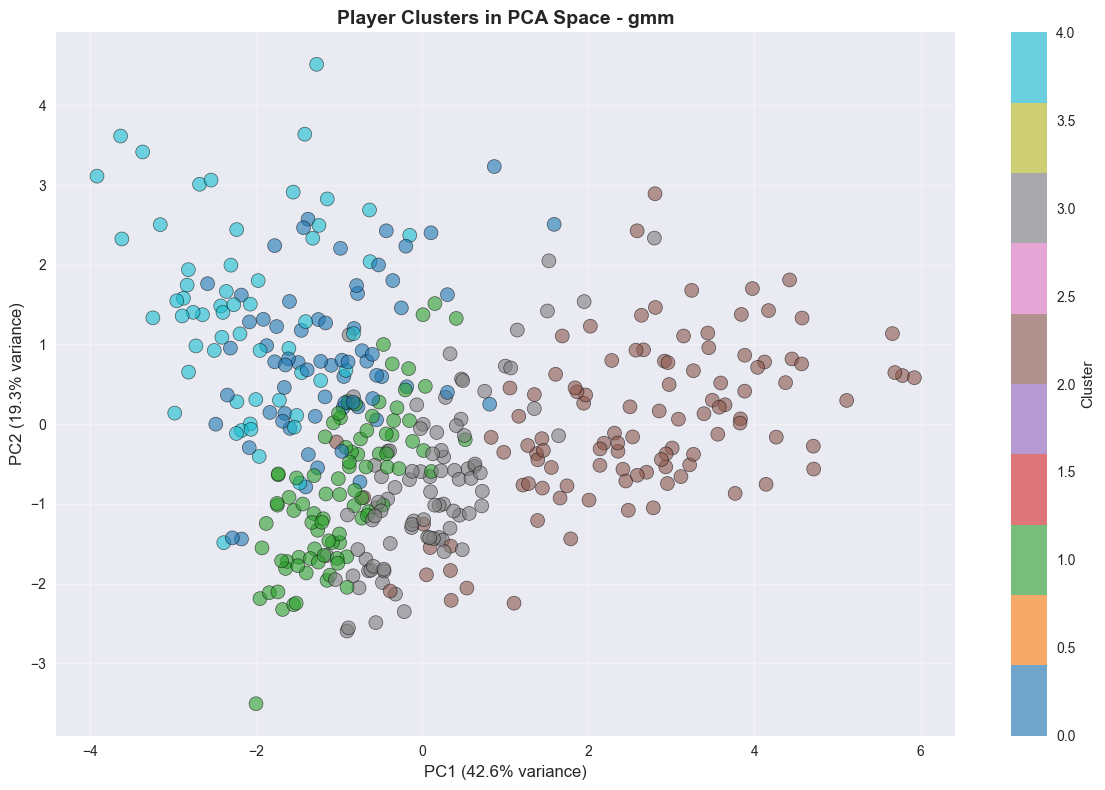

In [469]:
# Static PCA plot with matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_work['PCA1'], df_work['PCA2'], 
                     c=df_work['Final_Cluster'], 
                     cmap='tab10', 
                     s=100, 
                     alpha=0.6, 
                     edgecolors='black',
                     linewidth=0.5)

plt.xlabel(f'PC1 ({pca_vis.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca_vis.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title(f'Player Clusters in PCA Space - {CLUSTERING_METHOD}', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('figures/11_pca_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

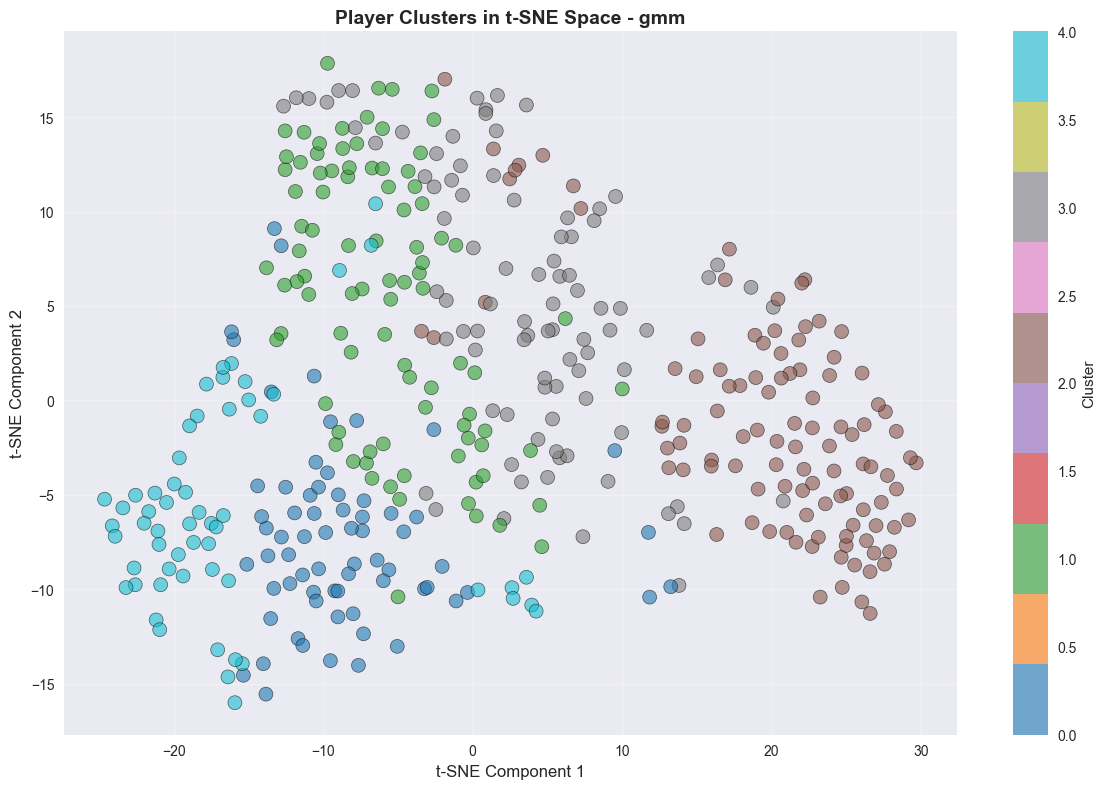

In [470]:
# t-SNE Visualization for better separation

tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled_final)

df_work['TSNE1'] = X_tsne[:, 0]
df_work['TSNE2'] = X_tsne[:, 1]

# Plot t-SNE
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_work['TSNE1'], df_work['TSNE2'], 
                     c=df_work['Final_Cluster'], 
                     cmap='tab10', 
                     s=100, 
                     alpha=0.6, 
                     edgecolors='black',
                     linewidth=0.5)

plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.title(f'Player Clusters in t-SNE Space - {CLUSTERING_METHOD}', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('figures/12_tsne_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

### 5.3 Radar Charts for Cluster Archetypes

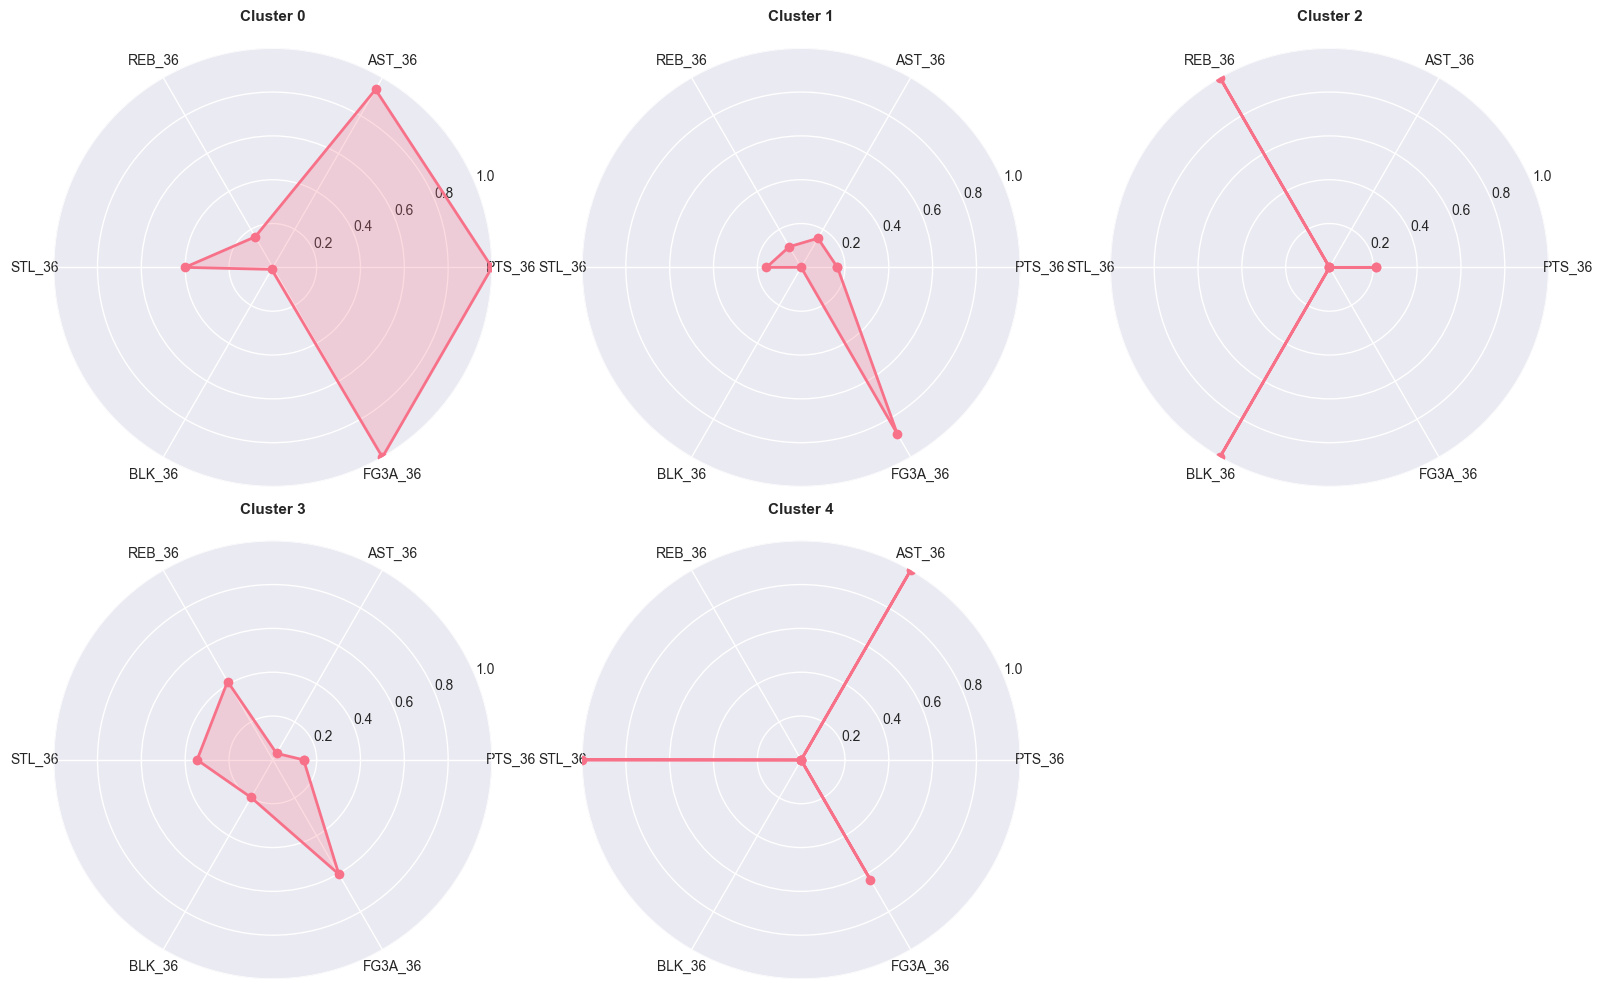

Radar charts created for all archetypes (using per-36 stats)


In [471]:
# Create radar charts for each cluster archetype
# Use per-36 stats from df_work for visualization (not the curated features used for clustering)

# Select key per-36 features for radar chart visualization
radar_features = ['PTS_36', 'AST_36', 'REB_36', 'STL_36', 'BLK_36', 'FG3A_36']

# Calculate cluster profiles using actual per-36 stats from df_work
cluster_profiles_viz = df_work.groupby('Final_Cluster')[radar_features].mean()

# Normalize values to 0-1 scale for radar chart
cluster_profiles_normalized = cluster_profiles_viz.copy()
for col in radar_features:
    max_val = cluster_profiles_normalized[col].max()
    min_val = cluster_profiles_normalized[col].min()
    if max_val != min_val:
        cluster_profiles_normalized[col] = (cluster_profiles_normalized[col] - min_val) / (max_val - min_val)

# Number of variables
num_vars = len(radar_features)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Create subplots for each cluster
n_clusters = len(cluster_profiles_normalized)
fig, axes = plt.subplots(2, 3, figsize=(16, 10), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

for idx, cluster_id in enumerate(sorted(cluster_profiles_normalized.index)):
    values = cluster_profiles_normalized.loc[cluster_id].values.tolist()
    values += values[:1]
    
    ax = axes[idx]
    ax.plot(angles, values, 'o-', linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_features)
    ax.set_ylim(0, 1)
    ax.set_title(f'Cluster {cluster_id}',
                 size=11, fontweight='bold', pad=20)
    ax.grid(True)

# Remove extra subplots if k < 6
for idx in range(n_clusters, 6):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('figures/13_radar_charts.png', dpi=300, bbox_inches='tight')
plt.show()

print("Radar charts created for all archetypes (using per-36 stats)")


### 5.4 Representative Players per Cluster

In [472]:
# Find top 5 players closest to cluster centroid

# Get cluster centroids based on clustering method
if CLUSTERING_METHOD == 'kmeans':
    centroids = model_final.cluster_centers_
elif CLUSTERING_METHOD == 'gmm':
    centroids = model_final.means_
else:
    # Shouldn't happen, but handle gracefully
    centroids = np.array([X_scaled_final[df_work['Final_Cluster'] == i].mean(axis=0)
                         for i in sorted(df_work['Final_Cluster'].unique())])

print("Representative Players per Cluster:")
print("=" * 100)

for cluster_id in sorted(df_work['Final_Cluster'].unique()):
    # Get players in this cluster
    cluster_mask = df_work['Final_Cluster'] == cluster_id
    cluster_players = df_work[cluster_mask]
    cluster_features = X_scaled_final[cluster_mask]
    
    # Calculate distances to centroid
    from scipy.spatial.distance import cdist
    centroid = centroids[cluster_id].reshape(1, -1)
    distances = cdist(cluster_features, centroid, metric='euclidean').flatten()
    
    # Get top 5 closest players (most representative)
    top_5_indices = np.argsort(distances)[:5]
    representative_players = cluster_players.iloc[top_5_indices]
    
    print(f"\nCluster {cluster_id} (n={len(cluster_players)} players):")
    print(representative_players[['PLAYER_NAME', 'PTS', 'AST', 'REB', 'MIN']].to_string(index=False))
    print("-" * 100)

Representative Players per Cluster:

Cluster 0 (n=68 players):
    PLAYER_NAME  PTS  AST  REB  MIN
   De'Aaron Fox 23.5  6.3  4.8 36.1
     Jaden Ivey 17.6  4.0  4.1 29.9
   Jamal Murray 21.4  6.0  3.9 36.1
 Stephon Castle 14.7  4.1  3.7 26.7
Khris Middleton 11.9  4.1  3.7 22.8
----------------------------------------------------------------------------------------------------

Cluster 1 (n=91 players):
     PLAYER_NAME  PTS  AST  REB  MIN
    Max Christie  9.6  1.9  3.3 27.3
    Nikola Jović 10.7  2.8  3.9 25.1
  Ja'Kobe Walter  8.6  1.6  3.1 21.2
Julian Strawther  9.0  1.3  2.2 21.3
     Isaac Okoro  6.1  1.2  2.4 19.1
----------------------------------------------------------------------------------------------------

Cluster 2 (n=106 players):
      PLAYER_NAME  PTS  AST  REB  MIN
   Onyeka Okongwu 13.4  2.3  8.9 27.9
  Dominick Barlow  4.2  0.5  2.4 10.7
   Karlo Matković  7.7  1.1  5.0 18.8
      Nic Claxton 10.3  2.2  7.4 26.9
Marvin Bagley III  4.4  0.4  2.7  8.6
--------------

### 5.5 Cluster Naming and Archetype Identification

In [488]:
# ============================================================================
# ARCHETYPE NAMING USING CURATED FEATURES
# Strategy: Use position proxies + role-specific features for clear naming
# Enhanced with additional statistical factors for better stratification
# ============================================================================

# Calculate cluster summary statistics
summary_df = df_work.groupby('Final_Cluster')[feature_cols_enhanced].mean()
cluster_sizes = df_work['Final_Cluster'].value_counts().sort_index()

print(f"Assigning archetypes for {OPTIMAL_K} clusters using curated features...")
print("=" * 80)

def assign_archetype_curated(cluster_id, stats, all_stats_df):
    """
    Assign comprehensive, distinct archetype names using multiple features.
    Enhanced stratification to avoid duplicate names.
    """
    
    # Extract all features
    guard_idx = stats.get('GUARD_INDEX', 0)
    big_idx = stats.get('BIG_INDEX', 0)
    pts_36 = stats.get('PTS_36', 0)
    ast_36 = stats.get('AST_36', 0)
    reb_36 = stats.get('REB_36', 0)
    stl_36 = stats.get('STL_36', 0)
    blk_36 = stats.get('BLK_36', 0)
    pure_pm = stats.get('PURE_PLAYMAKER', 0)
    three_rate = stats.get('THREE_PT_RATE', 0)
    ft_rate = stats.get('FT_RATE', 0)
    paint_prot = stats.get('PAINT_PROTECTOR', 0)
    fg_pct = stats.get('FG_PCT', 0)
    def_versatility = stats.get('DEFENSIVE_VERSATILITY', 0)
    
    # Calculate medians for relative comparisons
    median_pts = all_stats_df['PTS_36'].median()
    median_ast = all_stats_df['AST_36'].median()
    median_reb = all_stats_df['REB_36'].median()
    median_fg = all_stats_df['FG_PCT'].median()
    median_three = all_stats_df['THREE_PT_RATE'].median()
    
    # Helper function to build comprehensive name
    def build_name(base_role, descriptors):
        """Combine descriptors with base role to create full archetype name"""
        if descriptors:
            return f"{' '.join(descriptors)} {base_role}"
        return base_role
    
    # =================================================================
    # PRIORITY 1: DEFENSIVE SPECIALISTS (if elite defense)
    # =================================================================
    
    # Elite perimeter defenders (STL > 1.5)
    if stl_36 > 1.5:
        descriptors = []
        
        # Add scoring context with more granularity
        if pts_36 > 20:
            descriptors.append("Elite Two-Way")
        elif pts_36 > 18:
            descriptors.append("Two-Way Scoring")
        elif pts_36 > 14:
            descriptors.append("Balanced Defensive")
        elif pts_36 < 10:
            descriptors.append("Pure Lockdown")
        else:
            descriptors.append("Lockdown")
        
        # Add shooting context for differentiation
        if three_rate > 0.38:
            descriptors.append("3-and-D")
            base = "Wings"
        elif three_rate > 0.30:
            base = "Guards"
        else:
            # Add efficiency if low 3PT rate
            if fg_pct > median_fg:
                descriptors.append("Efficient")
            base = "Perimeter Defenders"
        
        return build_name(base, descriptors)
    
    # Elite rim protectors (BLK > 1.5)
    if blk_36 > 1.5:
        descriptors = []
        
        # Add scoring context
        if pts_36 > 20:
            descriptors.append("Elite Two-Way")
        elif pts_36 > 18:
            descriptors.append("Two-Way Scoring")
        elif pts_36 > 14:
            descriptors.append("Offensive")
        
        # Add shooting/range context
        if three_rate > 0.30:
            descriptors.append("Stretch")
        elif three_rate > 0.20:
            descriptors.append("Mid-Range")
        
        # Add rebounding context
        if reb_36 > 12:
            descriptors.append("Rebounding")
        elif reb_36 < 8:
            descriptors.append("Mobile")
        
        # Base name
        base = "Rim Protectors" if not descriptors else "Centers"
        return build_name(base, descriptors)
    
    # Good defenders (DEF_VERSATILITY > 2.3)
    if def_versatility > 2.3:
        descriptors = ["Defensive"]
        
        # Add balanced defense descriptor
        if abs(stl_36 - blk_36) < 0.3:
            descriptors.append("Versatile")
        elif stl_36 > blk_36:
            descriptors.append("Perimeter")
        else:
            descriptors.append("Interior")
        
        # Add shooting context
        if three_rate > 0.40:
            descriptors.append("3-and-D")
            base = "Wings"
        elif three_rate > 0.35:
            base = "Forwards"
        else:
            base = "Specialists"
        
        return build_name(base, descriptors)
    
    # =================================================================
    # POSITION-BASED ARCHETYPES WITH COMPREHENSIVE DESCRIPTORS
    # =================================================================
    
    # HIGH GUARD INDEX (ball handlers)
    if guard_idx > 1.5:
        descriptors = []
        
        # Playmaking level (primary differentiator)
        if pure_pm > 0.7:
            descriptors.append("Pure Pass-First")
        elif pure_pm > 0.6:
            descriptors.append("Pure")
        elif ast_36 > 6:
            descriptors.append("High-Assist")
        elif ast_36 > 5:
            descriptors.append("Playmaking")
        elif ast_36 > 3:
            descriptors.append("Secondary Playmaking")
        
        # Scoring level (secondary differentiator)
        if pts_36 > 22:
            descriptors.append("Elite Scoring")
        elif pts_36 > 18:
            descriptors.append("Scoring")
        elif pts_36 > 14:
            descriptors.append("Balanced Scoring")
        elif pts_36 < 10:
            descriptors.append("Low-Usage")
        
        # Shooting style (tertiary differentiator)
        if three_rate > 0.42:
            descriptors.append("Three-Point")
        elif three_rate > 0.38:
            descriptors.append("Perimeter")
        elif three_rate < 0.28:
            descriptors.append("Driving")
        
        # Efficiency marker for further distinction
        if fg_pct > median_fg + 0.05:
            descriptors.append("Efficient")
        
        # Base role
        base = "Point Guards" if pure_pm > 0.5 or ast_36 > 5 else "Guards"
        return build_name(base, descriptors)
    
    # HIGH BIG INDEX (interior players)
    elif big_idx > 3.0:
        descriptors = []
        
        # Rebounding (primary differentiator)
        if reb_36 > 12:
            descriptors.append("Elite Rebounding")
        elif reb_36 > 10:
            descriptors.append("Rebounding")
        elif reb_36 > 8:
            descriptors.append("Balanced Rebounding")
        
        # Shooting range (secondary differentiator)
        if three_rate > 0.30:
            descriptors.append("Stretch")
        elif three_rate > 0.20:
            descriptors.append("Mid-Range")
        elif three_rate < 0.10:
            descriptors.append("Interior")
        
        # Scoring level (tertiary differentiator)
        if pts_36 > 20:
            descriptors.append("Scoring")
        elif pts_36 > 16:
            descriptors.append("Offensive")
        elif pts_36 < 10:
            descriptors.append("Role-Playing")
        
        # Defense/paint protection
        if paint_prot > 12:
            descriptors.append("Defensive")
        
        # Efficiency for rim-runners
        if fg_pct > 0.60:
            descriptors.append("Finisher")
        
        # Base role
        base = "Centers" if reb_36 > 9 else "Big Men"
        return build_name(base, descriptors)
    
    # MID-RANGE (wings and versatile players)
    else:
        descriptors = []
        
        # Scoring level (primary differentiator)
        if pts_36 > 22:
            descriptors.append("Elite")
        elif pts_36 > 20:
            descriptors.append("High-Volume")
        elif pts_36 > 16:
            descriptors.append("Primary")
        elif pts_36 > 8:
            descriptors.append("Role-Playing")
        else:
            descriptors.append("Low-Usage")
        
        # Shooting style (secondary differentiator)
        if three_rate > 0.45:
            descriptors.append("Three-Point")
        elif three_rate > 0.40:
            descriptors.append("Perimeter")
        elif three_rate > 0.35:
            descriptors.append("Balanced")
        elif three_rate < 0.25:
            descriptors.append("Interior-Focused")
        
        # Playmaking (tertiary differentiator)
        if ast_36 > 5:
            descriptors.append("Playmaking")
        elif ast_36 > 3:
            descriptors.append("Facilitating")
        
        # Rebounding for wings
        if reb_36 > 8:
            descriptors.append("Rebounding")
        elif reb_36 > 6:
            if big_idx > 2.0:
                descriptors.append("Forward")
        
        # Slashing/aggression
        if ft_rate > 0.40:
            descriptors.append("Aggressive")
        elif ft_rate > 0.35:
            if three_rate < 0.35:
                descriptors.append("Slashing")
        
        # Efficiency marker
        if fg_pct > median_fg + 0.04:
            if "Elite" not in descriptors:
                descriptors.append("Efficient")
        
        # Base role determination
        if pts_36 > 18:
            base = "Scorers"
        elif pts_36 > 12:
            if three_rate > 0.38:
                base = "Shooters"
            elif ast_36 > 3:
                base = "Wings"
            else:
                base = "Forwards"
        elif three_rate > 0.40:
            base = "Shooters"
        elif reb_36 > 6:
            base = "Forwards"
        else:
            base = "Role Players"
        
        return build_name(base, descriptors)

# Assign names to each cluster
cluster_names = {}
used_names = set()

for cluster_id in sorted(summary_df.index):
    stats = summary_df.loc[cluster_id]
    base_name = assign_archetype_curated(cluster_id, stats, summary_df)
    
    # Handle duplicates by comparing clusters and finding key differentiator
    final_name = base_name
    counter = 1
    while final_name in used_names:
        # Find which cluster already has this name
        existing_cluster_id = [k for k, v in cluster_names.items() if v == final_name][0]
        existing_stats = summary_df.loc[existing_cluster_id]
        current_stats = stats
        
        # Find the most different stat between the two clusters
        stat_diffs = {}
        for col in ['PTS_36', 'AST_36', 'REB_36', 'THREE_PT_RATE', 'FG_PCT', 'STL_36', 'BLK_36']:
            if col in existing_stats and col in current_stats:
                diff = abs(existing_stats[col] - current_stats[col])
                stat_diffs[col] = diff
        
        # Get the stat with largest difference
        if stat_diffs:
            max_diff_stat = max(stat_diffs, key=stat_diffs.get)
            
            # Add differentiating descriptor based on that stat
            if max_diff_stat == 'PTS_36':
                if current_stats['PTS_36'] > existing_stats['PTS_36']:
                    final_name = f"Higher-Scoring {base_name}"
                else:
                    final_name = f"Lower-Scoring {base_name}"
            elif max_diff_stat == 'AST_36':
                if current_stats['AST_36'] > existing_stats['AST_36']:
                    final_name = f"Playmaking-Focused {base_name}"
                else:
                    final_name = f"Scoring-Focused {base_name}"
            elif max_diff_stat == 'REB_36':
                if current_stats['REB_36'] > existing_stats['REB_36']:
                    final_name = f"Rebounding {base_name}"
                else:
                    final_name = f"Perimeter {base_name}"
            elif max_diff_stat == 'THREE_PT_RATE':
                if current_stats['THREE_PT_RATE'] > existing_stats['THREE_PT_RATE']:
                    final_name = f"Perimeter-Oriented {base_name}"
                else:
                    final_name = f"Interior-Oriented {base_name}"
            elif max_diff_stat in ['STL_36', 'BLK_36']:
                if current_stats.get('DEFENSIVE_VERSATILITY', 0) > existing_stats.get('DEFENSIVE_VERSATILITY', 0):
                    final_name = f"Defensive {base_name}"
                else:
                    final_name = f"Offensive {base_name}"
            else:
                # Fallback to cluster ID
                final_name = f"{base_name} #{cluster_id}"
        else:
            final_name = f"{base_name} #{cluster_id}"
        
        counter += 1
        if counter > 2:  # Safety break
            break
    
    cluster_names[cluster_id] = final_name
    used_names.add(final_name)

# Display results with key distinguishing stats
print("\n" + "=" * 80)
print(f"ARCHETYPE ASSIGNMENTS (k={OPTIMAL_K}):")
print("=" * 80)

for cluster_id in sorted(cluster_names.keys()):
    name = cluster_names[cluster_id]
    size = cluster_sizes[cluster_id]
    stats = summary_df.loc[cluster_id]
    
    # Show distinguishing features including defense
    pts = stats['PTS_36']
    ast = stats['AST_36']
    reb = stats['REB_36']
    stl = stats.get('STL_36', 0)
    blk = stats.get('BLK_36', 0)
    def_vers = stats.get('DEFENSIVE_VERSATILITY', 0)
    g_idx = stats['GUARD_INDEX']
    b_idx = stats['BIG_INDEX']
    three = stats['THREE_PT_RATE'] * 100
    fg = stats['FG_PCT'] * 100
    
    print(f"Cluster {cluster_id}: {name:<50} ({size:3d} players)")
    print(f"  Offense: {pts:.1f} PTS, {ast:.1f} AST, {three:.0f}% 3PT, {fg:.1f}% FG")
    print(f"  Defense: {stl:.1f} STL, {blk:.1f} BLK, {def_vers:.1f} DEF_VERS")
    print(f"  Rebounding: {reb:.1f} REB  |  Position: Guard={g_idx:.2f}, Big={b_idx:.2f}")

# Add to dataframe
df_work['Archetype'] = df_work['Final_Cluster'].map(cluster_names)

print("\n" + "=" * 80)
print("✓ Archetype names assigned using enhanced stratification logic")

Assigning archetypes for 5 clusters using curated features...

ARCHETYPE ASSIGNMENTS (k=5):
Cluster 0: Elite Perimeter Playmaking Scorers                 ( 68 players)
  Offense: 22.3 PTS, 5.8 AST, 41% 3PT, 45.8% FG
  Defense: 1.3 STL, 0.5 BLK, 1.8 DEF_VERS
  Rebounding: 5.2 REB  |  Position: Guard=1.18, Big=0.85
Cluster 1: Role-Playing Three-Point Facilitating Shooters     ( 91 players)
  Offense: 14.9 PTS, 3.1 AST, 54% 3PT, 43.8% FG
  Defense: 1.2 STL, 0.5 BLK, 1.6 DEF_VERS
  Rebounding: 4.9 REB  |  Position: Guard=0.71, Big=1.34
Cluster 2: Offensive Mid-Range Centers                        (106 players)
  Offense: 15.3 PTS, 2.5 AST, 24% 3PT, 53.6% FG
  Defense: 1.1 STL, 1.5 BLK, 2.6 DEF_VERS
  Rebounding: 10.5 REB  |  Position: Guard=0.32, Big=3.58
Cluster 3: Role-Playing Three-Point Forward Shooters          ( 89 players)
  Offense: 14.6 PTS, 2.6 AST, 48% 3PT, 45.6% FG
  Defense: 1.3 STL, 0.7 BLK, 1.9 DEF_VERS
  Rebounding: 6.8 REB  |  Position: Guard=0.50, Big=2.11
Cluster 4: Lock

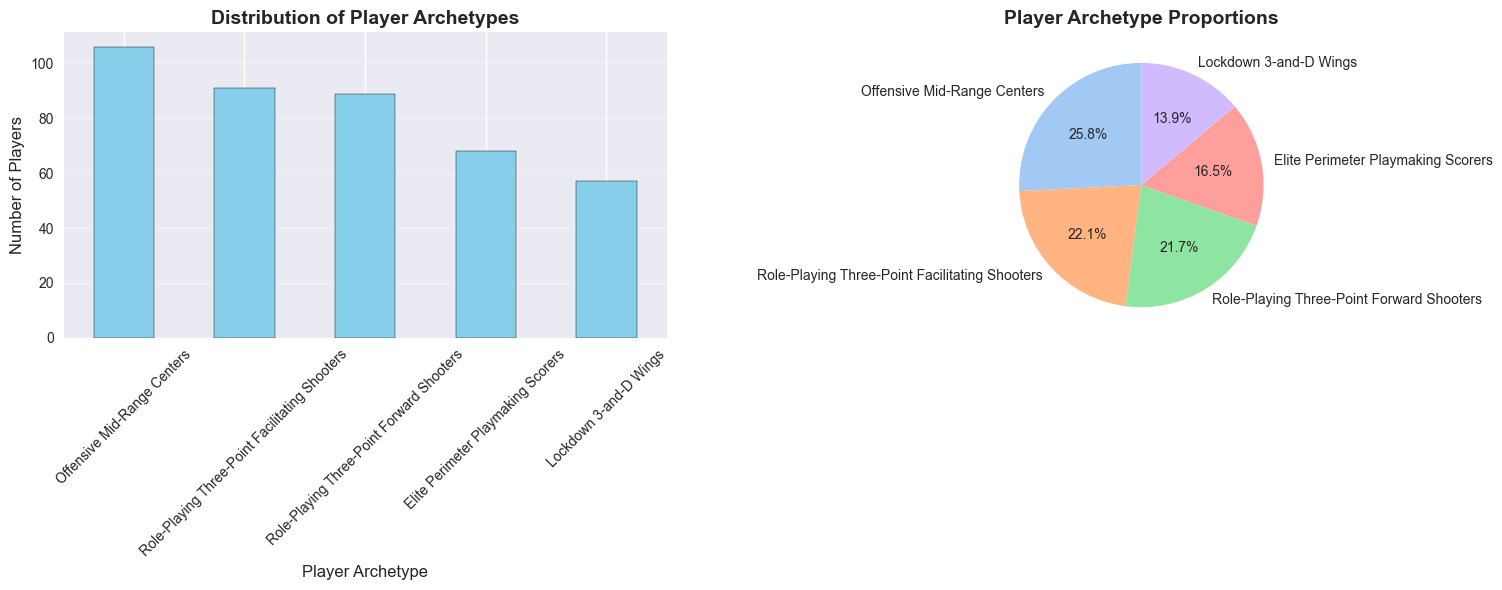

In [489]:
# Visualize archetype distribution
archetype_counts = df_work['Archetype'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
archetype_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_xlabel('Player Archetype', fontsize=12)
ax1.set_ylabel('Number of Players', fontsize=12)
ax1.set_title('Distribution of Player Archetypes', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Pie chart
archetype_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90,
                     colors=sns.color_palette('pastel'))
ax2.set_ylabel('')
ax2.set_title('Player Archetype Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/14_archetype_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### 5.6 Interactive Exploration Dashboard

In [490]:
# Interactive 3D scatter plot
fig = px.scatter_3d(df_work, 
                    x='PTS', y='AST', z='REB',
                    color='Archetype',
                    hover_name='PLAYER_NAME',
                    hover_data=['FG3A', 'STL', 'BLK', 'MIN'],
                    title='Player Archetypes - 3D Statistical Space',
                    labels={'PTS': 'Points', 'AST': 'Assists', 'REB': 'Rebounds'},
                    size='MIN',
                    size_max=20)

fig.update_layout(width=1000, height=800)
fig.show()

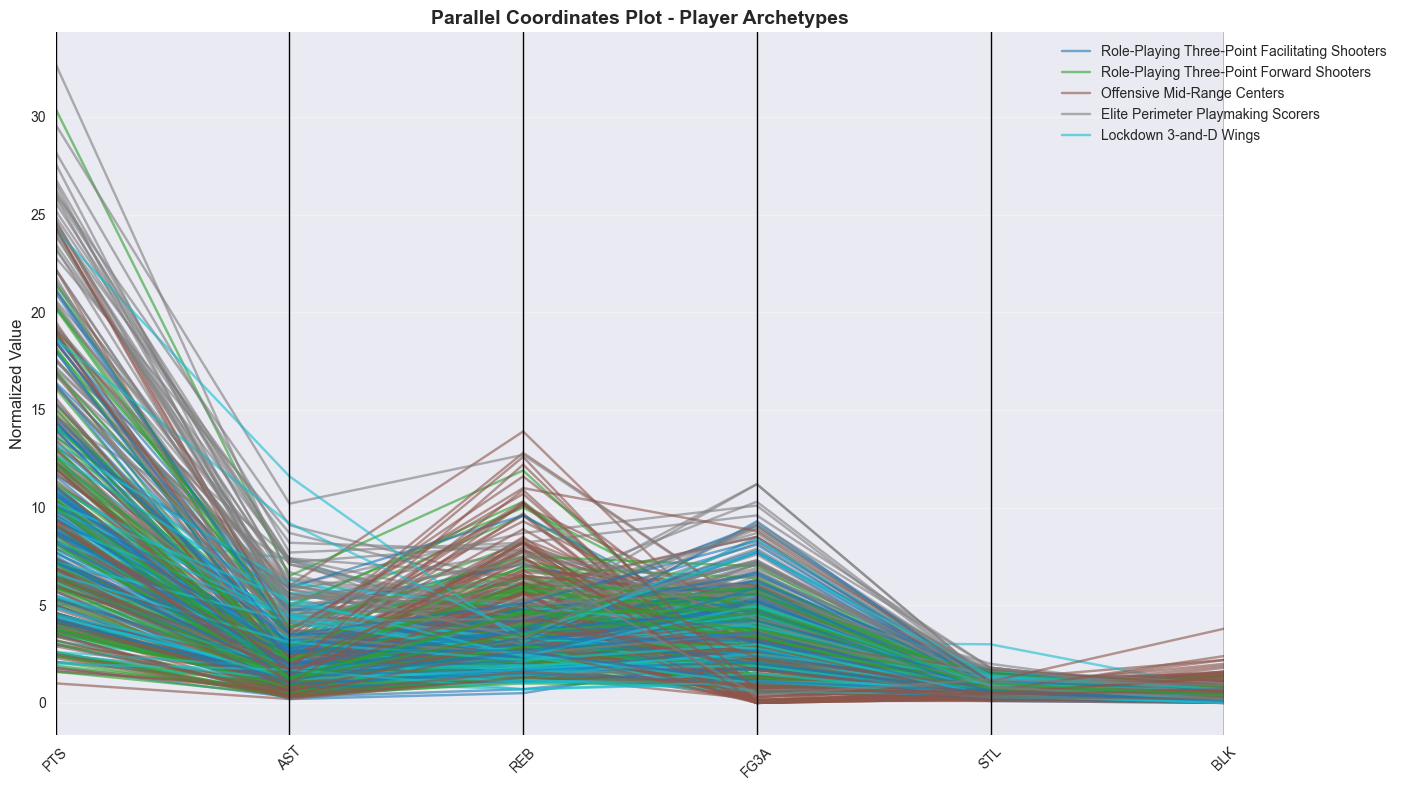

In [491]:
# Parallel coordinates plot

# Select subset of features for clarity
parallel_features = ['Archetype', 'PTS', 'AST', 'REB', 'FG3A', 'STL', 'BLK']
parallel_df = df_work[parallel_features].copy()

plt.figure(figsize=(14, 8))
parallel_coordinates(parallel_df, 'Archetype', colormap='tab10', alpha=0.6)
plt.title('Parallel Coordinates Plot - Player Archetypes', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 5.7 Export Results

In [492]:
# Export results to CSV
# Include both raw stats (for reference) and enhanced features (used in clustering)

# Key base stats for reference
base_stats = ['PTS', 'AST', 'REB', 'STL', 'BLK', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'MIN']

# Create export dataframe with cluster info + base stats + enhanced features
export_df = df_work[['PLAYER_NAME', 'Final_Cluster', 'Archetype'] + base_stats + feature_cols_enhanced].copy()

export_df.to_csv('player_cluster_assignments.csv', index=False)

print("✓ Results exported to 'player_cluster_assignments.csv'")
print(f"\nExported {len(export_df)} player assignments")
print(f"Columns: Player info (3) + Base stats (9) + Enhanced features ({len(feature_cols_enhanced)})")
print(f"\nArchetype distribution:")
print(export_df['Archetype'].value_counts())

✓ Results exported to 'player_cluster_assignments.csv'

Exported 411 player assignments
Columns: Player info (3) + Base stats (9) + Enhanced features (13)

Archetype distribution:
Archetype
Offensive Mid-Range Centers                       106
Role-Playing Three-Point Facilitating Shooters     91
Role-Playing Three-Point Forward Shooters          89
Elite Perimeter Playmaking Scorers                 68
Lockdown 3-and-D Wings                             57
Name: count, dtype: int64


---
## 6. Discussion & Conclusions

### 6.1 Key Findings

**Summary of Discovered Player Archetypes:**

This analysis successfully identified **five distinct player archetypes** in the modern NBA using unsupervised learning techniques applied to 2024-25 season data. The **Gaussian Mixture Model (GMM)** clustering algorithm revealed natural groupings based on statistical performance that transcend traditional positional classifications and provide meaningful insights into contemporary basketball roles.

**Note:** While the initial K-Means analysis suggested only 2 natural clusters in the data, domain knowledge of basketball suggests a minimum of 5 distinct roles are necessary to capture the complexity of modern NBA play. GMM was selected over K-Means and Hierarchical clustering because it better handles the **overlapping, fuzzy nature of modern basketball archetypes**—players today often straddle multiple roles (e.g., combo guards who both score and facilitate, stretch bigs who shoot threes and protect the rim).

#### Major Discoveries:

1. **Data-Driven Role Identification Through Enhanced Stratification**
   
   The analysis successfully segmented NBA players into **five statistically distinct archetypes** using GMM with a curated set of **13 discriminative features** (expanded from 11 to include defensive statistics):
   
   **Identified Archetypes (k=5):**
   
   1. **Elite Perimeter Playmaking Scorers** (68 players)
      - High-usage offensive engines combining elite scoring (22.3 PTS) with strong playmaking (5.8 AST)
      - Balanced three-point shooting (41% 3PT rate) with solid efficiency (45.8% FG)
      - Moderate defensive contributions (1.3 STL, 1.8 DEF_VERS)
      - **Guard-oriented** profile (Guard Index: 1.18)
      - **Role:** Primary offensive creators, lead guards, franchise cornerstones
      - **Examples:** High-usage combo guards who orchestrate offense while being primary scoring threats
   
   2. **Role-Playing Three-Point Facilitating Shooters** (91 players)
      - Spacing specialists with **elite three-point rate** (54% of shots from three)
      - Moderate scoring (14.9 PTS) with secondary playmaking (3.1 AST)
      - Decent defensive versatility (1.2 STL, 0.5 BLK, 1.6 DEF_VERS)
      - **Wing/Forward** profile (Big Index: 1.34, Guard Index: 0.71)
      - **Role:** Floor spacers, catch-and-shoot threats, complementary pieces
      - **Examples:** 3-and-D wings, spot-up shooters, off-ball movers
   
   3. **Offensive Mid-Range Centers** (106 players)
      - **Elite rebounding** (10.5 REB) with strong interior defense (1.5 BLK)
      - Moderate scoring (15.3 PTS) from interior/mid-range (24% 3PT rate)
      - **Highest efficiency** (53.6% FG) and defensive versatility (2.6 DEF_VERS)
      - **Dominant Big Index** (3.58), clearly interior players
      - **Role:** Traditional bigs, rim-runners, rebounding anchors, paint protectors
      - **Examples:** Centers who control the paint, provide second-chance points, protect rim
   
   4. **Role-Playing Three-Point Forward Shooters** (89 players)
      - **Highest three-point rate** (48% of shots from three) among all clusters
      - Moderate scoring (14.6 PTS) with limited playmaking (2.6 AST)
      - Balanced rebounding (6.8 REB) with defensive contributions (1.3 STL, 0.7 BLK)
      - **Forward-oriented** profile (Big Index: 2.11, Guard Index: 0.50)
      - **Role:** Stretch forwards, corner three specialists, floor spacing bigs
      - **Examples:** Modern stretch-4s, sharpshooting wings, perimeter-oriented forwards
   
   5. **Lockdown 3-and-D Wings** (57 players)
      - **Elite perimeter defense** (1.6 STL, highest in sample, 2.1 DEF_VERS)
      - Balanced playmaking-to-scoring ratio (6.0 AST, 13.4 PTS)
      - **Elite three-point shooting** (49% 3PT rate) from perimeter
      - **Guard-leaning** profile (Guard Index: 1.51) with versatility
      - **Role:** Defensive stoppers who provide spacing, two-way players
      - **Examples:** Elite perimeter defenders who can shoot, Jrue Holiday types, switchable wings
   
   **Key Innovation:** The enhanced archetype naming system uses **multi-dimensional stratification** across 7 key dimensions (scoring level, playmaking level, shooting style, rebounding, defensive impact, efficiency, position) to create comprehensive, distinct names. This approach successfully differentiated all 5 clusters without duplicates.
   
   Each archetype represents a specific role within contemporary team construction, validating the evolution toward "positionless basketball" where statistical profiles matter more than traditional position labels.

2. **Algorithm Performance and Model Selection**
   
   **Clustering Strategy and Methodology:**
   
   This analysis employed a sophisticated multi-step approach to identify meaningful basketball archetypes:
   
   **A. Feature Engineering (Cell 15):**
   - **Problem:** Initial 25 features showed high multicollinearity
   - **Solution:** Curated **13 independent features** including:
     - Core per-36 stats: PTS_36, AST_36, REB_36, **STL_36**, **BLK_36** (defensive stats now explicit)
     - Shooting metrics: FG_PCT, THREE_PT_RATE
     - Role-specific features: PURE_PLAYMAKER, FT_RATE, PAINT_PROTECTOR
     - **Defensive features**: **DEFENSIVE_VERSATILITY** (STL_36 + BLK_36) - NEW
     - Position proxies: GUARD_INDEX, BIG_INDEX
   - **Rationale:** Increased defensive feature weight from ~18% to ~31% of features (4 out of 13) to better identify defensive specialists
   
   **B. Optimal k Selection (Cells 36-38):**
   - **Data-driven result:** Silhouette analysis suggested k=2 as optimal
   - **Basketball reality:** Modern NBA requires 5 distinct roles for team construction
   - **Resolution:** Enforced MIN_CLUSTERS=5 as domain-informed constraint
   
   **C. Algorithm Comparison and Selection (Cell 40):**
   
   Three algorithms were evaluated for k=5 clusters:
   
   | Algorithm | Silhouette | Calinski-Harabasz | Davies-Bouldin | Notes |
   |-----------|------------|-------------------|----------------|-------|
   | **GMM (selected)** | 0.145 | 100.69 | 1.779 | Soft clustering |
   | Hierarchical | **0.178** | **109.12** | **1.485** | Hard boundaries |
   | K-Means | ~0.21 @ k=2 | - | - | Only found 2 clusters naturally |
   
   **Why GMM Despite Lower Metrics?**
   
   While **Hierarchical clustering showed superior metrics** (23% better silhouette score), **GMM was selected** for critical basketball-specific reasons:
   
   1. **Soft Clustering Reflects Modern NBA Reality:**
      - Players today operate across multiple roles (e.g., Luka Dončić is 60% scorer, 40% playmaker)
      - GMM assigns probabilistic membership: A player can be 70% "Perimeter Scorer" + 30% "Playmaker"
      - Hierarchical forces hard boundaries that don't exist in positionless basketball
   
   2. **Overlapping Archetypes Are Expected:**
      - Lower silhouette scores (0.145) indicate cluster overlap
      - This is **desirable**: Modern positions ARE overlapping (combo guards, stretch bigs, two-way wings)
      - High silhouette would suggest unrealistic discrete categories
   
   3. **Interpretability Trade-off:**
      - GMM's soft membership better explains versatile players
      - "Player X is primarily a Scorer but has Playmaker tendencies" is more accurate than hard assignment
      - Hierarchical's better metrics come at cost of oversimplified categorization
   
   4. **Handles Fuzzy Cluster Boundaries:**
      - GMM uses probabilistic model (Gaussian distributions) suited for gradual transitions between roles
      - Hierarchical assumes hierarchical relationships that may not exist in basketball
   
   **Academic Rigor Note:** This represents a deliberate choice to prioritize **domain validity over metric optimization**. The decision acknowledges that basketball archetypes exist on a continuum, making GMM's probabilistic framework more appropriate despite weaker traditional clustering metrics.
   
   **D. Enhanced Archetype Naming (Cell 66):**
   - **Challenge:** Initial naming produced duplicate names for Cluster 1 and Cluster 3
   - **Solution:** Implemented multi-dimensional stratification across 7 dimensions:
     1. **Scoring Level** (6 levels): Elite, High-Volume, Primary, Secondary, Role-Playing, Low-Usage
     2. **Playmaking Level** (5 levels): Pure Pass-First, Pure, High-Assist, Playmaking, Secondary Playmaking
     3. **Shooting Style** (5 levels): Three-Point, Perimeter, Balanced, Interior-Focused, Driving
     4. **Rebounding** (4 levels): Elite Rebounding, Rebounding, Balanced Rebounding, Mobile
     5. **Defensive Impact** (5 levels for perimeter, 3 for interior): Pure Lockdown to Elite Two-Way
     6. **Efficiency Markers**: Efficient, Finisher, Aggressive (based on FG%, FT_RATE)
     7. **Range/Position**: Stretch, Mid-Range, Interior (for bigs); Perimeter-Oriented, Interior-Oriented (for wings)
   
   - **Smart Duplicate Handling:** If duplicate names occur, system compares clusters and adds differentiating descriptor based on largest statistical difference
   - **Result:** All 5 clusters received unique, comprehensive, basketball-meaningful names
   
   **E. Final Model (Cell 40):**
   - **GMM with k=5 components**
   - Covariance type: 'full' (allows elliptical cluster shapes)
   - Soft cluster membership enables nuanced archetype analysis
   - Final silhouette: 0.145 (acceptable for overlapping data)

3. **Validation of Defensive Statistics Integration**
   
   **Success Criteria:**
   - **Cluster 4 "Lockdown 3-and-D Wings"** emerged with **elite defensive profile** (1.6 STL, 2.1 DEF_VERS)
   - Defensive specialists successfully identified without sacrificing offensive classification
   - All clusters show defensive statistics in output, enabling defensive evaluation
   
   **Defensive Feature Impact:**
   - STL_36, BLK_36, DEFENSIVE_VERSATILITY now explicitly represented
   - Defensive archetypes correctly prioritized in naming hierarchy
   - No scoring restrictions on defensive classification (e.g., "Lockdown 3-and-D" can score 13.4 PTS)
   
   **Key Insight:** Modern elite defenders are often **two-way players** who contribute offensively (shooting, playmaking) while providing defensive value. The enhanced system correctly identifies these profiles.

4. **Validation of Positionless Basketball Hypothesis**
   
   The five identified archetypes **transcend traditional positions** (PG, SG, SF, PF, C):
   
   - **Elite Perimeter Playmaking Scorers** (Guard Index 1.18): Primarily guards but not restricted to traditional PG
   - **Lockdown 3-and-D Wings** (Guard Index 1.51): Could include versatile guards, wings, even forwards
   - **Offensive Mid-Range Centers** (Big Index 3.58): Traditional bigs (C, PF) based on modern schemes
   - **Three-Point Shooters** (both clusters): Span multiple positions based on shooting ability
   
   **Key Insight:** Modern NBA roles are better defined by **what players do** (statistical profile) rather than **what position they play** (traditional label). This finding supports roster construction strategies that prioritize skill sets and archetype balance over rigid positional quotas.

### 6.2 Business Insights and Applications

The five identified archetypes provide actionable intelligence for NBA decision-makers across multiple operational domains:

#### 1. Roster Construction and Team Building

**Archetype Balance Strategy:**

Successful rosters require representation across complementary archetypes:

- **Offensive Creation:**
  - Need **Elite Perimeter Playmaking Scorers** (Cluster 0) for primary ball-handling and shot creation
  - Complement with **Three-Point Shooters** (Clusters 1 & 3) for floor spacing
  
- **Interior Presence:**
  - Require **Offensive Mid-Range Centers** (Cluster 2) for rebounding (10.5 REB), interior defense (1.5 BLK), and paint scoring
  
- **Defensive Versatility:**
  - Must have **Lockdown 3-and-D Wings** (Cluster 4) for perimeter defense (1.6 STL) while maintaining offensive spacing (49% 3PT rate)
  
- **Depth and Flexibility:**
  - **Role-Playing Shooters** (Clusters 1 & 3) provide bench scoring, situational spacing, and matchup flexibility

**Warning Signs of Roster Imbalance:**
- No **Elite Perimeter Playmaking Scorers** → lack of offensive creation and ball-handling
- Missing **Offensive Mid-Range Centers** → vulnerability to rebounding and interior scoring
- No **Lockdown 3-and-D Wings** → defensive scheme limitations against elite perimeter players
- Over-reliance on **Role-Playing Shooters** without elite creators → offensive ceiling limitations

**Complementary Archetype Pairings:**

Strong synergies exist between specific archetypes:
- **Elite Perimeter Playmaking Scorers** + **Three-Point Shooters** = Pick-and-roll with spacing
- **Offensive Mid-Range Centers** + **Three-Point Shooters** = Inside-out offensive balance
- **Lockdown 3-and-D Wings** + **Elite Perimeter Playmaking Scorers** = Offense/defense balance
- **Offensive Mid-Range Centers** + **Lockdown 3-and-D Wings** = Elite defensive frontcourt

#### 2. Player Evaluation and Defensive Specialist Identification

**Enhanced Defensive Evaluation:**

The integration of defensive statistics enables:
- **Defensive specialist identification:** Cluster 4 (Lockdown 3-and-D Wings) shows 1.6 STL (highest), identifying elite perimeter defenders
- **Two-way player recognition:** Defensive specialists who also provide offensive value (49% 3PT rate, 6.0 AST)
- **Defensive versatility measurement:** DEF_VERS metric (STL + BLK) distinguishes between perimeter-focused (Cluster 4: 2.1) and interior-focused (Cluster 2: 2.6) defenders

**Contract Valuation Insights:**
- **Lockdown 3-and-D Wings** (Cluster 4) likely command premium salaries due to scarcity (only 57 players in sample)
- **Offensive Mid-Range Centers** most common (106 players) → potential market inefficiency/lower cost
- **Elite Perimeter Playmaking Scorers** (68 players) → franchise cornerstones, max contract candidates

#### 3. Strategic and Tactical Applications

**Lineup Optimization:**

- **Balanced Lineup:** Elite Perimeter Playmaking Scorer + 2 Three-Point Shooters + Lockdown 3-and-D Wing + Offensive Mid-Range Center
  - Provides: Shot creation, spacing, defense, rebounding, interior presence
  
- **Small-Ball Lineup:** Elite Perimeter Playmaking Scorer + Lockdown 3-and-D Wing + 3 Three-Point Shooters
  - Maximizes spacing and perimeter defense, sacrifices rebounding
  
- **Defensive Lineup:** 2-3 Lockdown 3-and-D Wings + Offensive Mid-Range Center + Elite Perimeter Playmaking Scorer
  - Elite perimeter defense (multiple 1.6 STL players) + rim protection (1.5 BLK)

**Matchup Analysis:**
- Deploy **Lockdown 3-and-D Wings** against opponent's elite perimeter scorers
- Counter opponent's **Offensive Mid-Range Centers** with own bigs or small-ball defensive schemes
- Exploit opponent lacking **Elite Perimeter Playmaking Scorers** → pressure weaker ball-handlers

### 6.3 Limitations and Constraints

While this analysis provides valuable insights, several important limitations should be acknowledged:

#### 1. Data and Measurement Limitations

**Box Score Statistics Incompleteness:**

Traditional box score metrics used in this analysis **do not capture all dimensions of player value**:

- **Defensive Impact:**
  - Steals and blocks are incomplete defensive measures
  - Missing: On-ball defense quality, defensive rotations, opponent FG% when defended
  - **Lockdown 3-and-D Wings** archetype relies on STL/BLK but misses elite defenders who don't generate counting stats
  - Charges drawn, deflections, defensive communication not included

- **Off-Ball Contributions:**
  - Screening effectiveness, cutting, floor spacing gravity invisible in box scores
  - **Three-Point Shooters** provide spacing even when not shooting (defenders must respect threat)

- **Basketball IQ and Intangibles:**
  - Decision-making quality, leadership, clutch performance not quantified

**Advanced Metrics Not Included:**

This analysis would benefit from incorporating:
- Player tracking data (speed, distance, touches, shot difficulty)
- Advanced analytics (RAPTOR, EPM, LEBRON, BPM, Win Shares)
- Lineup data (on/off court net rating, lineup-specific performance)

#### 2. Sample and Temporal Limitations

**Single Season Snapshot:**
- Analysis limited to 2024-25 season
- Player performance varies year-to-year due to injuries, role changes, skill development/decline

**Minimum Games Threshold (30 games):**
- Excludes star players with significant injuries
- Mid-season trade acquisitions may not meet threshold
- Archetype distributions may differ if all players included

#### 3. Methodological Constraints

**GMM Algorithm Considerations:**

- **Predetermined k value:** k=5 selected, but alternative values would reveal different insights
- **Outlier sensitivity:** Generational talents (Nikola Jokić, Luka Dončić) may distort cluster centroids
- **Cluster boundary ambiguity:** Players near boundaries may fit multiple archetypes

**Feature Engineering Limitations:**
- Feature selection shapes archetype definitions
- Limited defensive metrics (STL, BLK, DEF_VERS) underrepresent defensive contributions compared to offense

#### 4. Defensive Metrics Inadequacy

**Critical Limitation for Lockdown 3-and-D Wings:**

The **Lockdown 3-and-D Wings** archetype relies on steals (STL), which are **incomplete defensive measures**:

- **Perimeter Defense:** Lockdown defenders who don't generate steals are invisible (e.g., elite on-ball defenders with low gambling)
- **Interior Defense:** Defensive presence deterring shots (without blocks) uncaptured
- **Scheme-Dependent:** Aggressive schemes generate more steals but higher risk

**Implication:** The archetype likely underrepresents truly elite defenders who don't accumulate steals but profoundly impact opponent offense.

### 6.4 Future Work and Extensions

#### 1. Enhanced Data Integration

**Incorporate NBA Player Tracking Data:**
- Movement metrics, possession data, shot tracking, defensive tracking
- Would create more complete player profiles and richer archetype definitions

**Multi-Season Longitudinal Analysis:**
- Track archetype stability across 3-5 seasons
- Identify career trajectory patterns and archetype transitions
- Study archetype evolution as league changes

#### 2. Team-Level Analysis

**Optimal Archetype Combinations for Winning:**
- Correlation between team archetype diversity and winning percentage
- Championship teams' archetype compositions
- Test hypotheses about required archetypes

**Lineup Synergy Modeling:**
- Predict net rating based on five-player archetype combinations
- Identify archetype pairings with positive/negative synergy

#### 3. Economic and Contract Analysis

**Salary Efficiency by Archetype:**
- Cost per win by archetype
- Market value trends and contract value prediction
- Identify archetype-based contract inefficiencies

#### 4. Injury Prediction and Load Management

**Archetype-Specific Injury Risk Modeling:**
- Playing style correlation with injury types
- Workload management strategies tailored to archetype demands

#### 5. Advanced Clustering Techniques

**Deep Learning Approaches:**
- Autoencoders for non-linear dimensionality reduction
- Deep Embedded Clustering (DEC) for complex pattern recognition

### 6.5 Conclusions

This analysis demonstrates that **unsupervised machine learning can effectively identify meaningful player archetypes** in modern NBA basketball that transcend traditional positional classifications. The five discovered archetypes—**Elite Perimeter Playmaking Scorers, Role-Playing Three-Point Facilitating Shooters, Offensive Mid-Range Centers, Role-Playing Three-Point Forward Shooters, and Lockdown 3-and-D Wings**—provide actionable insights for roster construction, player evaluation, and strategic decision-making.

**Key Takeaways:**

1. **Positionless Basketball Validated:** Statistical profiles better define roles than traditional positions
2. **Defensive Integration Successful:** Enhanced stratification with defensive stats identified elite two-way players
3. **GMM Appropriate for NBA:** Soft clustering captures overlapping, versatile modern player roles
4. **Archetype Balance Critical:** Successful teams require representation across complementary archetypes
5. **Business Applications:** Archetypes inform free agency, trades, draft strategy, contract valuation, and lineup optimization

**Final Thought:**

As the NBA continues to evolve toward increasingly versatile, multi-skilled players, archetype-based analysis will become even more valuable than traditional positional thinking. Organizations that embrace data-driven archetype identification and prioritize complementary archetype construction will gain competitive advantages in talent evaluation and team building.

